In [1]:
# First, install the required packages
#!pip install pandas mysql-connector-python matplotlib seaborn scipy

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import mysql.connector
import warnings

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 130)

# Ignore warnings
warnings.filterwarnings('ignore')

# Set seaborn style
sns.set_style("whitegrid")


# Domain Analysis

Bank GoodCredit wants to predict cred score for current credit card customers. The credit score will denote a customer’s credit worthiness and help the bank in reducing credit default risk. We were given access to three tables related to customer credit data: the Customers Account Table, Enquiry Table, and Customer Demographics Table.

The Customers Account Table contains information about each customer's account history, such as the type of account, credit limit, balance amount, payment history, and credit utilization. This table can be used to analyze customer behavior and predict creditworthiness, such as by computing credit utilization ratios, identifying customers with high past-due amounts or default risk, or predicting customer credit scores.

The Enquiry Table contains information about each customer's credit enquiries, such as the enquiry date, purpose, and amount. This table can be used to analyze customer behaviour and predict creditworthiness, such as by identifying customers with high levels of credit inquiries or using the enquiry purpose as a proxy for creditworthiness.

The Customer Demographics Table contains information about each customer's demographic features, such as age, gender, income, and education level. To protect the privacy of the customers, the features are obscured. This table can be used to analyze customer behaviour and predict creditworthiness, such as by identifying demographic factors that are correlated with creditworthiness or using the demographic features as input variables for predictive models.

Overall, by combining data from these three tables and applying various data analysis techniques, you can gain insights into customer behavior, predict creditworthiness, and help the bank reduce credit default risk. It's important to carefully evaluate the quality and completeness of the data, and to follow appropriate data privacy and security protocols to ensure the protection of customer data.

# Defining our Strategy

Our data is segregated into 3 databases. We have to import the data from these 3 databases. For simplicity we will read each database into a dataframe and then handle its data separately, including missing data handling and creating new features from existing features. In order to retain much of the data, after reading in the databases we will handle missing value first so that we may finally combine the dataframes into a single .csv file and then do all the necessary steps for exploratory data analysis and building machine learning models.

# Importing dataset from databases

In [2]:
# establishing a connection to the database
db = mysql.connector.connect(
    host="18.136.157.135",
    port="3306",
    user="dm_team1",
    password="DM!$Team&279@20!",
    database="project_banking"
)


# Basic checks
### Customers Account Data

In [3]:
Cust_Account = pd.read_sql("SELECT * FROM Cust_Account", con=db)

Cust_Account.to_csv("Customer_Accounts.csv")

In [4]:
Cust_Account = pd.read_csv("Customer_Accounts.csv").drop(["Unnamed: 0"],axis =1)
Cust_Account.head()

,dt_opened,customer_no,upload_dt,acct_type,owner_indic,opened_dt,last_paymt_dt,closed_dt,reporting_dt,high_credit_amt,cur_balance_amt,amt_past_due,paymenthistory1,paymenthistory2,paymt_str_dt,paymt_end_dt,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount
0,10-Nov-15,12265,20-Oct-15,6,1,09-Jun-13,30-Jun-14,05-Jul-14,30-Sep-15,20900.0,0,NaN,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",NaN,01-Sep-15,01-Jul-14,NaN,NaN,NaN,NaN,NaN
1,10-Nov-15,12265,20-Oct-15,10,1,25-May-12,06-Sep-15,NaN,03-Oct-15,16201.0,10390,NaN,"""""""0000000000000000000000000000000000000000000...","""""""000000000000000000000000000XXX0000000000000...",01-Oct-15,01-Nov-12,14000.0,1400.0,NaN,3.0,5603.0
2,10-Nov-15,12265,20-Oct-15,10,1,22-Mar-12,31-Aug-15,NaN,30-Sep-15,41028.0,34420,NaN,"""""""0000000000000000000000000000000000000000000...","""""""0000000000000000000000000000000000000000000...",01-Sep-15,01-Oct-12,NaN,NaN,NaN,NaN,NaN
3,20-Jul-15,15606,09-Jul-15,10,1,13-Jan-06,NaN,26-Jul-07,31-Jan-09,93473.0,0,NaN,"""""""1200900600600600300000000000000000000000000...",NaN,01-Jul-07,01-Feb-06,NaN,NaN,NaN,NaN,NaN
4,20-Jul-15,15606,09-Jul-15,6,1,18-Jan-15,05-May-15,NaN,31-May-15,20250.0,13500,NaN,"""""""000000000000000""""""",NaN,01-May-15,01-Jan-15,NaN,NaN,NaN,NaN,NaN


In [5]:
Cust_Account.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186329 entries, 0 to 186328
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_opened            186329 non-null  object 
 1   customer_no          186329 non-null  int64  
 2   upload_dt            186329 non-null  object 
 3   acct_type            186329 non-null  int64  
 4   owner_indic          186329 non-null  int64  
 5   opened_dt            185874 non-null  object 
 6   last_paymt_dt        160842 non-null  object 
 7   closed_dt            77254 non-null   object 
 8   reporting_dt         186329 non-null  object 
 9   high_credit_amt      177454 non-null  float64
 10  cur_balance_amt      186329 non-null  int64  
 11  amt_past_due         876 non-null     float64
 12  paymenthistory1      186329 non-null  object 
 13  paymenthistory2      78505 non-null   object 
 14  paymt_str_dt         186328 non-null  object 
 15  paymt_end_dt     

**Our Comments:**
There are a lot of missing values that need to be taken care of. Also we find that the dataframe contains some datetime columns that are provided as objects; we may convert these columns to datatime datatypes for better analysis.

In [6]:
Cust_Account.columns

Index(['dt_opened', 'customer_no', 'upload_dt', 'acct_type', 'owner_indic',
       'opened_dt', 'last_paymt_dt', 'closed_dt', 'reporting_dt',
       'high_credit_amt', 'cur_balance_amt', 'amt_past_due', 'paymenthistory1',
       'paymenthistory2', 'paymt_str_dt', 'paymt_end_dt', 'creditlimit',
       'cashlimit', 'rateofinterest', 'paymentfrequency',
       'actualpaymentamount'],
      dtype='object')

In [7]:
def find_missing(dataframe):
    missing_data_cols = dataframe.columns[dataframe.isnull().sum() > 0]
    null = dataframe.isnull().sum()
    null_df = pd.DataFrame(null,columns=["No_of_null_values"])
    null_df = null_df.loc[missing_data_cols]
    if len(null_df)>0:
        return null_df
    else:
        return "There are no null values!"

In [8]:
find_missing(Cust_Account)

,No_of_null_values
opened_dt,455
last_paymt_dt,25487
closed_dt,109075
high_credit_amt,8875
amt_past_due,185453
paymenthistory2,107824
paymt_str_dt,1
paymt_end_dt,1
creditlimit,137477
cashlimit,151047


**Our Comments:** There are a lot of missing values that need to be taken care of.

In [9]:
Cust_Account.describe()

,customer_no,acct_type,owner_indic,high_credit_amt,cur_balance_amt,amt_past_due,creditlimit,cashlimit,paymentfrequency,actualpaymentamount
count,186329.000000,186329.000000,186329.000000,1.774540e+05,1.863290e+05,8.760000e+02,4.885200e+04,35282.000000,63893.000000,4.105300e+04
mean,11431.820447,8.403104,1.122128,1.756104e+05,7.640269e+04,2.583151e+04,7.552881e+04,20608.503401,2.996212,3.016616e+04
std,6730.432139,5.179466,0.567040,9.842643e+05,6.186783e+05,2.030680e+05,7.174109e+04,24856.481410,0.086954,3.870822e+05
min,1.000000,0.000000,1.000000,1.000000e+00,-7.355205e+06,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000e+00
25%,5879.000000,6.000000,1.000000,2.297500e+04,0.000000e+00,1.535000e+02,3.100000e+04,7500.000000,3.000000,3.110000e+03
50%,11169.000000,10.000000,1.000000,4.522350e+04,0.000000e+00,1.209500e+03,6.000000e+04,12500.000000,3.000000,7.590000e+03
75%,16982.000000,10.000000,1.000000,1.060000e+05,2.099800e+04,7.663250e+03,1.000000e+05,27000.000000,3.000000,1.800000e+04
max,23896.000000,59.000000,4.000000,1.800000e+08,1.360100e+08,4.869309e+06,2.500000e+06,1000000.000000,3.000000,6.785322e+07


In [10]:
Cust_Account.describe(include="O")

,dt_opened,upload_dt,opened_dt,last_paymt_dt,closed_dt,reporting_dt,paymenthistory1,paymenthistory2,paymt_str_dt,paymt_end_dt,rateofinterest
count,186329,186329,185874,160842,77254,186329,186329,78505,186328,186328,24833
unique,197,75,6245,4510,4839,1877,18311,11911,233,234,1770
top,16-Nov-15,21-Apr-15,13-Apr-12,05-Mar-15,05-Mar-12,31-Jul-15,"""""""0000000000000000000000000000000000000000000...","""""""0000000000000000000000000000000000000000000...",01-Jul-15,01-Jan-15,39
freq,4643,5128,514,1739,353,12654,44979,18956,16747,5640,3211


**Our Comments:** In the customer accounts dataframe we find that there are a total of 186,329 customer information with different type of account types and their credit limit, current balance and due amount. We find that there are lot of amount that are past due , which can be bad for the company. We should ask the customers to increase their payment frequency who has the most amount that is past due.

### Customer Enquiry Data

In [11]:
Cust_Enquiry = pd.read_sql("SELECT * FROM Cust_Enquiry", con=db)
Cust_Enquiry.to_csv("Cust_Enquiry.csv")


In [12]:
Cust_Enquiry = pd.read_csv("Cust_Enquiry.csv").drop(["Unnamed: 0"],axis =1)

Cust_Enquiry.head()

,dt_opened,customer_no,upload_dt,enquiry_dt,enq_purpose,enq_amt
0,18-Apr-15,1,21-Apr-15,19-Dec-14,2.0,3500000.0
1,18-Apr-15,1,21-Apr-15,05-Mar-14,5.0,500000.0
2,18-Apr-15,1,21-Apr-15,05-Mar-14,0.0,50000.0
3,18-Apr-15,1,21-Apr-15,22-Feb-14,10.0,50000.0
4,18-Apr-15,1,21-Apr-15,11-Jun-13,10.0,1000.0


In [13]:
Cust_Enquiry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413188 entries, 0 to 413187
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt_opened    413188 non-null  object 
 1   customer_no  413188 non-null  int64  
 2   upload_dt    413078 non-null  object 
 3   enquiry_dt   413078 non-null  object 
 4   enq_purpose  413078 non-null  float64
 5   enq_amt      413078 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.9+ MB


**Our Comments:**  We find that the dataframe contains some datetime columns that are provided as objects; we may convert these columns to datatime datatypes for better analysis.

In [14]:
Cust_Enquiry.columns

Index(['dt_opened', 'customer_no', 'upload_dt', 'enquiry_dt', 'enq_purpose',
       'enq_amt'],
      dtype='object')

In [15]:
find_missing(Cust_Enquiry)

,No_of_null_values
upload_dt,110
enquiry_dt,110
enq_purpose,110
enq_amt,110


**Our Comments:** There are a some missing values that need to be taken care of.

In [16]:
Cust_Enquiry.describe()

,customer_no,enq_purpose,enq_amt
count,413188.000000,413078.000000,4.130780e+05
mean,11399.813414,8.154804,8.289094e+05
std,6672.675047,5.637857,1.204328e+07
min,1.000000,0.000000,1.000000e+00
25%,5999.000000,5.000000,1.000000e+04
50%,11067.000000,10.000000,5.000000e+04
75%,16856.000000,10.000000,1.430000e+05
max,23896.000000,59.000000,1.000000e+09


In [17]:
Cust_Enquiry.describe(include='O')

,dt_opened,upload_dt,enquiry_dt
count,413188,413078,413078
unique,197,75,3771
top,16-Nov-15,21-Apr-15,17-Mar-15
freq,10538,11770,495


**Our Comments:** The dataframe give us information about different customers enquring about their credit, the enquired amount and the enquired reason. It is safe to say the customers who are enquiring more and their enquired amount is more is more risky and may be delinquent

### Demographics Data

In [18]:
Cust_Demographics = pd.read_sql("SELECT * FROM Cust_Demographics", con=db)
Cust_Demographics.to_csv("Cust_Demographics.csv")

In [19]:
Cust_Demographics = pd.read_csv("Cust_Demographics.csv").drop(["Unnamed: 0"],axis =1)

Cust_Demographics.head()

,dt_opened,customer_no,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label
0,18-Apr-15,1,13-Apr-15,Insignia,13-Apr-15,650.0,2.0,Card Setup,14.0,500000.0,NaN,NaN,NaN,Y,IS1,NaN,0.0,159,4284,4284,NaN,1.0,ADFPNXXXXX,03-Sep-65,98332XXXXX,N,@REDIFFMAIL.COM,1.0,2.0,NaN,Mumbai / Navi Mumbai / Thane,400610.0,1965.0,0.0,Self,Y,2.0,90000.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Mumbai,400059.0,@CODOGNOTTO.NET,PAN Card,ADFPNXXXXX,The Ratnakar Bank Ltd.,NaN,Y,State Bank of India,0.0,01-Jun-13,17-Jun-16,1.0,21.0,NaN,Y,Y,N,NaN,Y,1965-0,21.0,15.0,400610.0,0.0,2.0,90000.0,Nov-00,21.0,R,NaN,NaN,0000-00-00,0.0,98332XXXXX,1.0,N,0
1,21-Apr-15,2,21-Apr-15,Insignia,21-Apr-15,760.0,1.0,Card Setup,14.0,1200000.0,NaN,NaN,NaN,Y,IS1,NaN,0.0,91,B001,4077,NaN,1.0,AJWPRXXXXX,14-Jul-62,99455XXXXX,N,@GMAIL.COM,1.0,2.0,NaN,Bengaluru,560042.0,1969.0,0.0,Self,Y,2.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Bangalore,560042.0,NaN,PAN Card,AJWPRXXXXX,The Ratnakar Bank Ltd.,NaN,N,NaN,0.0,NaN,17-Jun-16,1.0,17.0,NaN,Y,Y,N,NaN,Y,1969-0,17.0,12.0,560042.0,0.0,2.0,1.0,Nov-00,17.0,R,NaN,NaN,0000-00-00,0.0,99455XXXXX,1.0,N,0
2,22-Apr-15,3,21-Apr-15,Insignia,21-Apr-15,774.0,1.0,Card Setup,14.0,700000.0,NaN,NaN,NaN,Y,IS1,NaN,0.0,91,B001,4077,NaN,2.0,AFAPNXXXXX,10-Apr-66,98456XXXXX,N,@SHOBANARAYAN.COM,1.0,0.0,NaN,Bengaluru,560042.0,1966.0,0.0,Self,Y,2.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Bangalore,560042.0,NaN,PAN Card,AFAPNXXXXX,NaN,NaN,N,NaN,0.0,NaN,17-Jun-16,3.0,17.0,NaN,N,Y,N,NaN,Y,1966-0,17.0,12.0,560042.0,0.0,2.0,1.0,Nov-00,17.0,R,NaN,NaN,0000-00-00,0.0,98456XXXXX,1.0,N,0
3,25-Apr-15,4,15-Apr-15,Insignia,20-Apr-15,770.0,1.0,Card Setup,14.0,500000.0,NaN,NaN,NaN,Y,IS1,NaN,0.0,157,5107,5107,NaN,1.0,AAAPDXXXXX,16-Apr-64,98220XXXXX,N,@VSNL.COM,1.0,3.0,NaN,Pune,411001.0,1988.0,0.0,Self,Y,2.0,100000.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Pune,411026.0,@ALBAJ.COM,PAN Card,AAAPDXXXXX,The Ratnakar Bank Ltd.,NaN,Y,HDFC Bank,0.0,NaN,17-Jun-16,1.0,21.0,NaN,Y,Y,N,NaN,Y,1988-0,21.0,16.0,411001.0,0.0,2.0,100000.0,Nov-00,21.0,R,NaN,NaN,6/15/65,1.0,98220XXXXX,1.0,N,0
4,06-May-15,5,30-Apr-15,Insignia,NaN,NaN,3.0,Card Setup,14.0,500000.0,NaN,NaN,NaN,Y,IS1,NaN,0.0,100,D016,4564,NaN,1.0,ABEPSXXXXX,03-Jan-54,98111XXXXX,N,@REDIFFMAIL.COM,1.0,3.0,NaN,Gurgaon,122009.0,1995.0,0.0,Self,Y,2.0,300000.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Gurgaon,122009.0,NaN,PAN Card,ABEPSXXXXX,The Ratnakar Bank Ltd.,NaN,N,NaN,0.0,NaN,17-Jun-16,1.0,13.0,NaN,Y,Y,N,NaN,Y,1995-0,13.0,3.0,122009.0,0.0,2.0,300000.0,Nov-00,13.0,R,NaN,NaN,0000-00-00,0.0,98111XXXXX,1.0,N,0


In [20]:
Cust_Demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23896 entries, 0 to 23895
Data columns (total 83 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dt_opened    23896 non-null  object 
 1   customer_no  23896 non-null  int64  
 2   entry_time   23881 non-null  object 
 3   feature_1    23881 non-null  object 
 4   feature_2    21060 non-null  object 
 5   feature_3    21060 non-null  float64
 6   feature_4    23881 non-null  float64
 7   feature_5    23881 non-null  object 
 8   feature_6    23881 non-null  float64
 9   feature_7    23881 non-null  float64
 10  feature_8    1261 non-null   object 
 11  feature_9    1261 non-null   object 
 12  feature_10   51 non-null     object 
 13  feature_11   23881 non-null  object 
 14  feature_12   23881 non-null  object 
 15  feature_13   10892 non-null  object 
 16  feature_14   16163 non-null  float64
 17  feature_15   23873 non-null  object 
 18  feature_16   23869 non-null  object 
 19  feat

**Our Comments:** There are a lot of missing values that need to be taken care of. Also we find that the dataframe contains some datetime columns that are provided as objects; we may convert these columns to datatime datatypes for better analysis. On the other hand, there are not of features that has no understandable column name. We will need to check its data and guess the coulumn data and its importance

In [21]:
Cust_Demographics.columns

Index(['dt_opened', 'customer_no', 'entry_time', 'feature_1', 'feature_2',
       'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7',
       'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22',
       'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27',
       'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32',
       'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37',
       'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42',
       'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47',
       'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52',
       'feature_53', 'feature_54', 'feature_55', 'feature_56', 'feature_57',
       'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62',
       '

In [22]:
find_missing(Cust_Demographics)

,No_of_null_values
entry_time,15
feature_1,15
feature_2,2836
feature_3,2836
feature_4,15
feature_5,15
feature_6,15
feature_7,15
feature_8,22635
feature_9,22635


**Our Comments:** There are a lot of missing values that need to be taken care of. Also we find that the dataframe contains some datetime columns that are provided as objects; we may convert these columns to datatime datatypes for better analysis.

In [23]:
Cust_Demographics.describe()

,customer_no,feature_3,feature_4,feature_6,feature_7,feature_14,feature_19,feature_25,feature_26,feature_29,feature_30,feature_31,feature_34,feature_35,feature_39,feature_40,feature_41,feature_42,feature_44,feature_49,feature_52,feature_55,feature_56,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_71,feature_74,feature_76,feature_78,Bad_label
count,23896.000000,21060.000000,23881.000000,23881.0,2.388100e+04,16163.000000,23881.000000,23881.000000,23881.000000,23881.000000,23881.000000,23881.000000,23881.000000,2.388100e+04,23881.000000,23881.000000,23881.000000,23881.000000,23881.000000,1.040000e+02,2.388100e+04,23881.000000,23881.000000,23881.000000,23881.000000,23881.000000,23881.000000,23881.000000,2.388100e+04,23881.000000,17.000000,23881.000000,23881.000000,23896.000000
mean,11948.500000,723.235945,2.321595,14.0,1.190705e+05,8.086618,1.049412,1.233910,0.725640,217620.229346,2001.183996,0.652318,1.238851,3.278933e+04,1533.268707,3.348352,5.702609,0.154139,222251.238474,2.724312e+11,6.500073e+04,1.085717,13.337465,14.587454,157.609732,264374.021440,0.184373,1.238851,3.278933e+04,14.539048,2.411765,0.003852,1.043214,0.042015
std,6898.325352,37.318684,0.892838,0.0,7.752349e+04,5.625654,0.216731,0.423324,1.124986,159267.102213,11.993426,2.343709,0.430009,1.087860e+05,855.273257,3.587043,4.159316,0.930806,156846.154943,1.223114e+11,1.008225e+05,0.388569,8.285993,9.518517,190.979066,202001.890433,0.387796,0.430009,1.087860e+05,9.077906,0.618347,0.084286,0.224672,0.200628
min,1.000000,-1.000000,1.000000,14.0,0.000000e+00,0.000000,1.000000,1.000000,0.000000,110001.000000,1964.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,7.568570e+05,0.000000e+00,1.000000,2.000000,2.000000,1.000000,110001.000000,0.000000,1.000000,1.000000e+00,2.000000,2.000000,0.000000,1.000000,0.000000
25%,5974.750000,698.000000,1.000000,14.0,7.200000e+04,0.000000,1.000000,1.000000,0.000000,110051.000000,1991.000000,0.000000,1.000000,1.000000e+00,1999.000000,0.000000,1.000000,0.000000,110044.000000,3.090000e+11,0.000000e+00,1.000000,10.000000,10.000000,39.000000,110059.000000,0.000000,1.000000,1.000000e+00,10.000000,2.000000,0.000000,1.000000,0.000000
50%,11948.500000,721.000000,3.000000,14.0,1.040000e+05,12.000000,1.000000,1.000000,0.000000,110094.000000,2005.000000,0.000000,1.000000,3.000000e+04,2010.000000,2.000000,6.000000,0.000000,122001.000000,3.090000e+11,5.000000e+04,1.000000,10.000000,10.000000,157.000000,122012.000000,0.000000,1.000000,3.000000e+04,10.000000,2.000000,0.000000,1.000000,0.000000
75%,17922.250000,745.000000,3.000000,14.0,1.390000e+05,12.000000,1.000000,1.000000,2.000000,390002.000000,2011.000000,0.000000,1.000000,4.300000e+04,2013.000000,6.000000,10.000000,0.000000,390002.000000,3.090000e+11,1.000000e+05,1.000000,13.000000,21.000000,157.000000,400601.000000,0.000000,1.000000,4.300000e+04,17.000000,3.000000,0.000000,1.000000,0.000000
max,23896.000000,896.000000,3.000000,14.0,1.217000e+06,12.000000,2.000000,2.000000,10.000000,712245.000000,2015.000000,12.000000,3.000000,1.500000e+07,2015.000000,12.000000,11.000000,11.000000,712201.000000,8.090000e+11,3.777000e+06,4.000000,35.000000,35.000000,10008.000000,874401.000000,1.000000,3.000000,1.500000e+07,35.000000,4.000000,4.000000,3.000000,1.000000


In [24]:
Cust_Demographics.describe(include='O')

,dt_opened,entry_time,feature_1,feature_2,feature_5,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_15,feature_16,feature_17,feature_18,feature_20,feature_21,feature_22,feature_23,feature_24,feature_27,feature_28,feature_32,feature_33,feature_36,feature_37,feature_38,feature_43,feature_45,feature_46,feature_47,feature_48,feature_50,feature_51,feature_53,feature_54,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_70,feature_72,feature_73,feature_75,feature_77,feature_79
count,23896,23881,23881,21060,23881,1261,1261,51,23881,23881,10892,23873,23869,1027,18,23896,23881,23896,23881,23256,20259,23881,23881,23881,18214,18214,18214,23881,10183,23802,23896,5497,23881,12474,12286,23881,2393,23881,23881,23881,9,23881,23881,23881,23881,2945,23881,23896,23881
unique,197,296,7,281,1,19,19,9,2,16,14,364,522,302,12,10610,8462,3251,2,721,10,62,5,2,9,11,5663,70,4472,5,11250,56,2,10,180,1,2,2,2,2,8,2,491,133,2,2,62,3124,2
top,16-Nov-15,19-Oct-15,Platinum Maxima,19-Oct-15,Card Setup,ROTVR,Negative Office Tele Verification,3.09E+11,Y,PM1,PD3,SA03,AS19,5622,180,AXMPKXXXXX,01-Jan-85,99999XXXXX,N,@GMAIL.COM,Graduate,New Delhi,Self,Y,Private Ltd. Co.,Banking/Financial Services,MANAGER,New Delhi,@GMAIL.COM,PAN Card,XXXXX,HDFC Bank,Y,HDFC Bank,01-Jun-14,17-Jun-16,Y,N,Y,N,GNWX-B,Y,2010-0,0-0,R,Y,0000-00-00,XXXXX,N
freq,699,180,9056,182,23881,336,336,35,22611,8853,8416,9331,1374,169,5,16,33,194,21528,15595,14610,12539,10833,19478,8677,13187,1624,9760,1854,22796,94,1368,12565,5704,624,23881,2242,23425,22611,23563,2,23876,1670,18235,15617,2126,23820,2149,23876


**Our Comments:** We need to fully understand the features columns and guess its data it is trying to describe, then we can comment on this.

# Exploratory Data Analysis
### Customer Accounts Data

In [25]:
Cust_Account.head()

,dt_opened,customer_no,upload_dt,acct_type,owner_indic,opened_dt,last_paymt_dt,closed_dt,reporting_dt,high_credit_amt,cur_balance_amt,amt_past_due,paymenthistory1,paymenthistory2,paymt_str_dt,paymt_end_dt,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount
0,10-Nov-15,12265,20-Oct-15,6,1,09-Jun-13,30-Jun-14,05-Jul-14,30-Sep-15,20900.0,0,NaN,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",NaN,01-Sep-15,01-Jul-14,NaN,NaN,NaN,NaN,NaN
1,10-Nov-15,12265,20-Oct-15,10,1,25-May-12,06-Sep-15,NaN,03-Oct-15,16201.0,10390,NaN,"""""""0000000000000000000000000000000000000000000...","""""""000000000000000000000000000XXX0000000000000...",01-Oct-15,01-Nov-12,14000.0,1400.0,NaN,3.0,5603.0
2,10-Nov-15,12265,20-Oct-15,10,1,22-Mar-12,31-Aug-15,NaN,30-Sep-15,41028.0,34420,NaN,"""""""0000000000000000000000000000000000000000000...","""""""0000000000000000000000000000000000000000000...",01-Sep-15,01-Oct-12,NaN,NaN,NaN,NaN,NaN
3,20-Jul-15,15606,09-Jul-15,10,1,13-Jan-06,NaN,26-Jul-07,31-Jan-09,93473.0,0,NaN,"""""""1200900600600600300000000000000000000000000...",NaN,01-Jul-07,01-Feb-06,NaN,NaN,NaN,NaN,NaN
4,20-Jul-15,15606,09-Jul-15,6,1,18-Jan-15,05-May-15,NaN,31-May-15,20250.0,13500,NaN,"""""""000000000000000""""""",NaN,01-May-15,01-Jan-15,NaN,NaN,NaN,NaN,NaN


#### Lets first spilt the numerical and categorical features in the dataframe

In [26]:
cat_df = Cust_Account.select_dtypes('O')
num_df = Cust_Account.select_dtypes('number')

### Plotting Account types and its current balances

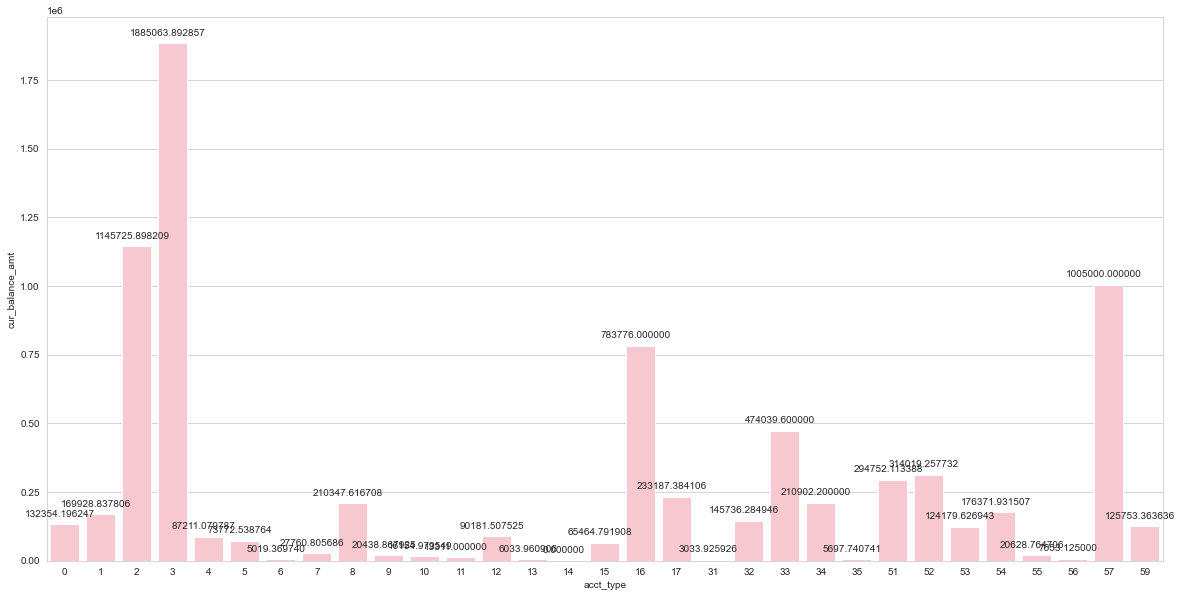

In [27]:
plt.figure(figsize=(20,10))
splot=sns.barplot(x='acct_type',y='cur_balance_amt',data=Cust_Account,color='pink',ci=None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.6f'), (p.get_x() + p.get_width() / 3., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10),textcoords = 'offset points')

**Our Findings:**

1. We find that the account types of 3,2,57 and 16 respectively has the highest current account balances. On the other hand 13,14,56.57 etc has the lowest balances.

2. Customers with account types that has low curent balances may look for credit more than customer with higher balances.

### Demographics Data

In [28]:
Cust_Demographics.head()

,dt_opened,customer_no,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label
0,18-Apr-15,1,13-Apr-15,Insignia,13-Apr-15,650.0,2.0,Card Setup,14.0,500000.0,NaN,NaN,NaN,Y,IS1,NaN,0.0,159,4284,4284,NaN,1.0,ADFPNXXXXX,03-Sep-65,98332XXXXX,N,@REDIFFMAIL.COM,1.0,2.0,NaN,Mumbai / Navi Mumbai / Thane,400610.0,1965.0,0.0,Self,Y,2.0,90000.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Mumbai,400059.0,@CODOGNOTTO.NET,PAN Card,ADFPNXXXXX,The Ratnakar Bank Ltd.,NaN,Y,State Bank of India,0.0,01-Jun-13,17-Jun-16,1.0,21.0,NaN,Y,Y,N,NaN,Y,1965-0,21.0,15.0,400610.0,0.0,2.0,90000.0,Nov-00,21.0,R,NaN,NaN,0000-00-00,0.0,98332XXXXX,1.0,N,0
1,21-Apr-15,2,21-Apr-15,Insignia,21-Apr-15,760.0,1.0,Card Setup,14.0,1200000.0,NaN,NaN,NaN,Y,IS1,NaN,0.0,91,B001,4077,NaN,1.0,AJWPRXXXXX,14-Jul-62,99455XXXXX,N,@GMAIL.COM,1.0,2.0,NaN,Bengaluru,560042.0,1969.0,0.0,Self,Y,2.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Bangalore,560042.0,NaN,PAN Card,AJWPRXXXXX,The Ratnakar Bank Ltd.,NaN,N,NaN,0.0,NaN,17-Jun-16,1.0,17.0,NaN,Y,Y,N,NaN,Y,1969-0,17.0,12.0,560042.0,0.0,2.0,1.0,Nov-00,17.0,R,NaN,NaN,0000-00-00,0.0,99455XXXXX,1.0,N,0
2,22-Apr-15,3,21-Apr-15,Insignia,21-Apr-15,774.0,1.0,Card Setup,14.0,700000.0,NaN,NaN,NaN,Y,IS1,NaN,0.0,91,B001,4077,NaN,2.0,AFAPNXXXXX,10-Apr-66,98456XXXXX,N,@SHOBANARAYAN.COM,1.0,0.0,NaN,Bengaluru,560042.0,1966.0,0.0,Self,Y,2.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Bangalore,560042.0,NaN,PAN Card,AFAPNXXXXX,NaN,NaN,N,NaN,0.0,NaN,17-Jun-16,3.0,17.0,NaN,N,Y,N,NaN,Y,1966-0,17.0,12.0,560042.0,0.0,2.0,1.0,Nov-00,17.0,R,NaN,NaN,0000-00-00,0.0,98456XXXXX,1.0,N,0
3,25-Apr-15,4,15-Apr-15,Insignia,20-Apr-15,770.0,1.0,Card Setup,14.0,500000.0,NaN,NaN,NaN,Y,IS1,NaN,0.0,157,5107,5107,NaN,1.0,AAAPDXXXXX,16-Apr-64,98220XXXXX,N,@VSNL.COM,1.0,3.0,NaN,Pune,411001.0,1988.0,0.0,Self,Y,2.0,100000.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Pune,411026.0,@ALBAJ.COM,PAN Card,AAAPDXXXXX,The Ratnakar Bank Ltd.,NaN,Y,HDFC Bank,0.0,NaN,17-Jun-16,1.0,21.0,NaN,Y,Y,N,NaN,Y,1988-0,21.0,16.0,411001.0,0.0,2.0,100000.0,Nov-00,21.0,R,NaN,NaN,6/15/65,1.0,98220XXXXX,1.0,N,0
4,06-May-15,5,30-Apr-15,Insignia,NaN,NaN,3.0,Card Setup,14.0,500000.0,NaN,NaN,NaN,Y,IS1,NaN,0.0,100,D016,4564,NaN,1.0,ABEPSXXXXX,03-Jan-54,98111XXXXX,N,@REDIFFMAIL.COM,1.0,3.0,NaN,Gurgaon,122009.0,1995.0,0.0,Self,Y,2.0,300000.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Gurgaon,122009.0,NaN,PAN Card,ABEPSXXXXX,The Ratnakar Bank Ltd.,NaN,N,NaN,0.0,NaN,17-Jun-16,1.0,13.0,NaN,Y,Y,N,NaN,Y,1995-0,13.0,3.0,122009.0,0.0,2.0,300000.0,Nov-00,13.0,R,NaN,NaN,0000-00-00,0.0,98111XXXXX,1.0,N,0


### Plotting Label Distribution

Text(0.5, 1.0, 'Bad Label Distribution')

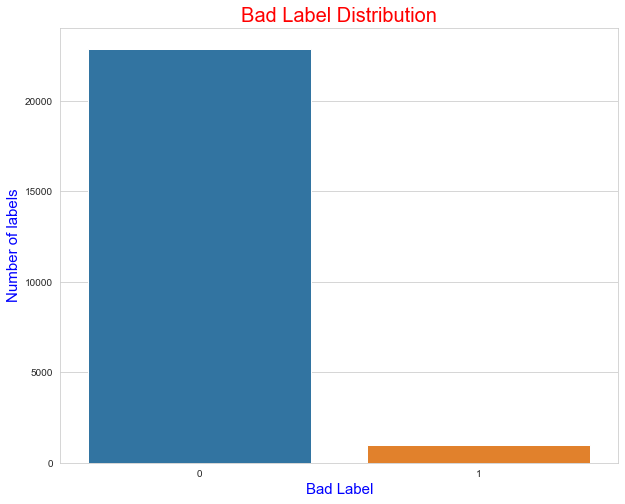

In [29]:
plt.figure(figsize=(10, 8))
plot = sns.countplot(x=Cust_Demographics['Bad_label'])
plt.xlabel("Bad Label", fontsize=15, color='blue')
plt.ylabel("Number of labels", fontsize=15, color='blue')
plt.title("Bad Label Distribution", fontdict={'fontsize': 20, 'color': 'red'})

**Our Findings:** We find that the dataset is highly imbalanced; we will need to take this into account when we are incorporating machine learning models

### Plotting the dates when account were opened the most

Text(0.5, 1.0, 'Count of Opened Date')

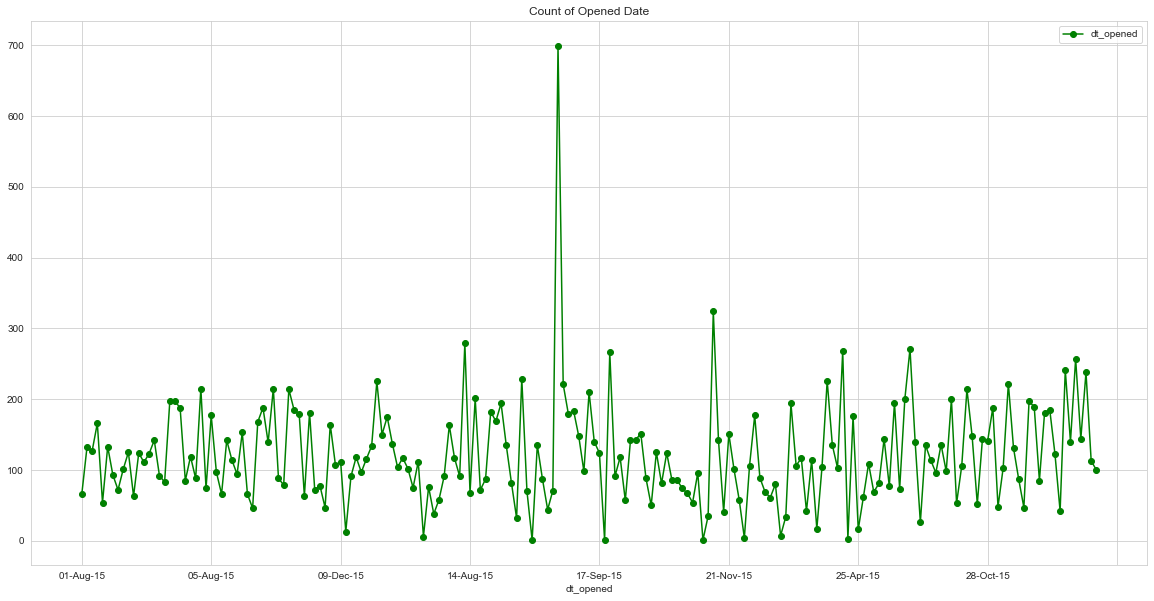

In [30]:
Cust_demo=Cust_Demographics.groupby(['dt_opened'])['dt_opened'].count().to_frame()
Cust_demo.plot(kind='line',figsize=[20,10],color='green',marker='o')
plt.title("Count of Opened Date")

**Our Findings:** We find that from 30the August 2015 to 8th September 2015 there were a signifincant jump in account openings. Since it was probably a very successful campaign; management should try to replicate the same campaign to increase accounts.

### Customer Enquiry data

In [31]:
Cust_Enquiry['customer_no'].value_counts()

10076    308
6775     254
6147     246
11922    214
12736    176
        ... 
23429      1
6891       1
12971      1
19588      1
4666       1
Name: customer_no, Length: 23896, dtype: int64

In [32]:
Cust_Enquiry['customer_no'].value_counts().index[:10]

Int64Index([10076, 6775, 6147, 11922, 12736, 8770, 22677, 6397, 10043, 16124], dtype='int64')

### Plotting the most enquired customers

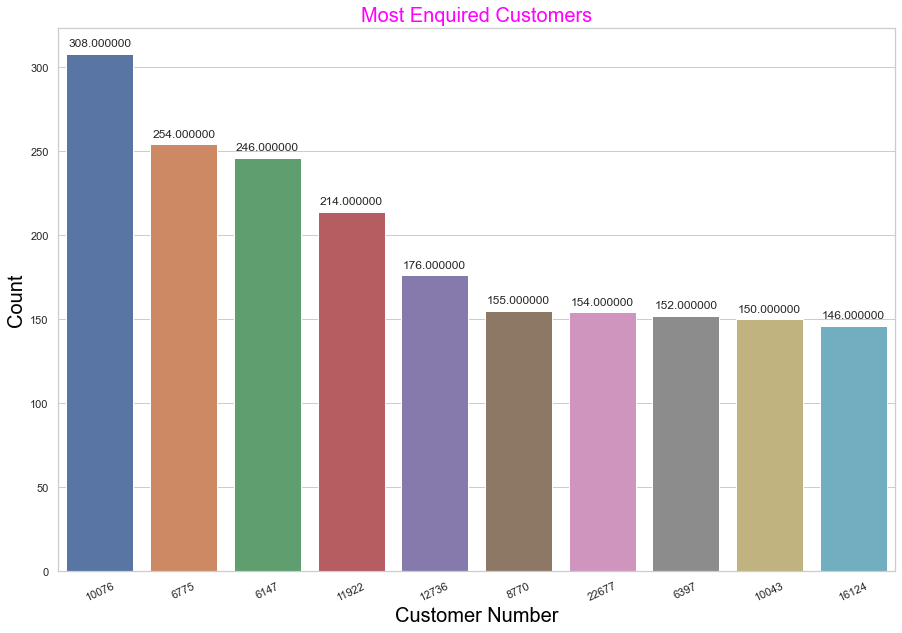

In [33]:
plt.figure(figsize=(15, 10))
sns.set(style='whitegrid')
splot = sns.countplot(x=Cust_Enquiry['customer_no'], order=Cust_Enquiry['customer_no'].value_counts().index[:10])
plt.xticks(rotation=25)
plt.xlabel('Customer Number', fontsize=20, color='black')
plt.ylabel('Count', fontsize=20, color='black')
plt.title("Most Enquired Customers", fontdict={'fontsize': 20, 'color': 'magenta'})

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.6f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


**Our Findings:** We find the top ten most enquired customers and their amounts. These customers may be in need of more credit; and they are also more prone to default.

### Plotting the most enquired purpose

In [34]:
Cust_Enquiry['enq_purpose'].value_counts().index[:10]

Float64Index([10.0, 5.0, 1.0, 6.0, 2.0, 0.0, 13.0, 51.0, 3.0, 7.0], dtype='float64')

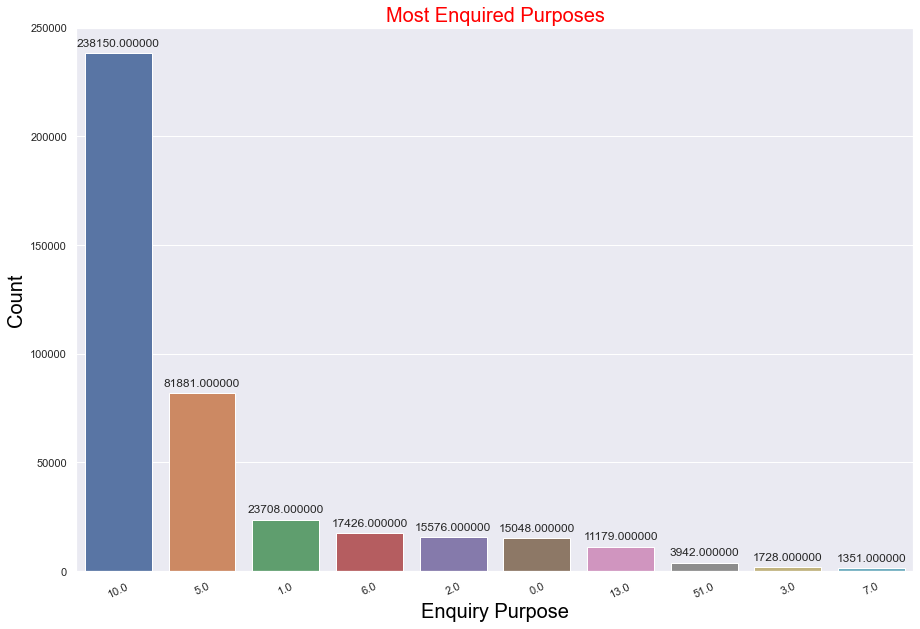

In [35]:
plt.figure(figsize=(15, 10))
sns.set(style='darkgrid')
splot = sns.countplot(x=Cust_Enquiry['enq_purpose'], order=Cust_Enquiry['enq_purpose'].value_counts().index[:10])
plt.xticks(rotation=25)
plt.xlabel('Enquiry Purpose', fontsize=20, color='black')
plt.ylabel('Count', fontsize=20, color='black')
plt.title("Most Enquired Purposes", fontdict={'fontsize': 20, 'color': 'red'})

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.6f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


**Our Findings:** We find the top ten most enquired purpose and their amounts. Purpose of 10 and 5 are the highest and 7 is the lowest. Purpose 10 should be throughly reviewed as it is unusally higher than other purposes and management should decide what need to be done for its enquring customers

# Data exploration insights

### Decision Regarding Dataset

After exploring the dataset along with the three tables that gave us various information about customer demographics, their enquiries and their personal banking information we have come up with the following decision regarding how to handle the datasets:


**Feature selection:** We need to assess the relevance and importance of individual features in the dataset. It is possible that certain features may not be informative or may introduce noise to the model. We should be evaluating feature importance using techniques such as feature importance scores from tree-based models or correlation analysis.

**Imbalanced class distribution:** We have found class imbalance in the dataset. Imbalanced classes can negatively impact the model's performance. As there is significant class imbalance existing, we will be employing techniques such as oversampling, undersampling, or utilizing algorithms specifically designed for imbalanced datasets (e.g., SMOTE, ADASYN) to address the issue.

**Hyperparameter tuning:** We need to optimize the hyperparameters of the chosen model to improve its performance. This can be done using techniques like grid search or randomized search, exploring different combinations of hyperparameters to find the optimal configuration for your dataset.

**Model selection:** We will be experimenting with different classification algorithms to identify the one that best suits the  data. Different algorithms have different strengths and may perform better for specific types of datasets. We will consider trying algorithms such as Random Forest, Decision Trees, Gradient Boosting Machines (GBM), or Neural Networks, among others.

**Data preprocessing:** We will ensure that the data is properly preprocessed, including handling missing values, scaling numerical features, and encoding categorical variables. Inadequate preprocessing can affect model performance, so we will assess and address any data preprocessing issues.

### Decision Regarding Insights Gained From Exploration

We have identified the customers that enquiring more about credit; these customers are prone to default and their transaction history and payment history should be checked before giving out new loans.

We want the management to take up the same campaign that was provided during Aug-2015 to Sept-2015 as it showed significant growth in new accounts.

We have identified the features of loan defaulters and these features will be checked every time a customer is being approved for a loan.

In order to gain more insights into the data, we need to do feature engineering.


## Generating the new features

Based on the given three dataframes, we will do feature engineering to make sure we gain more insights into the data

### Customers Account Data

In [36]:
Cust_Account = pd.read_sql("SELECT * FROM Cust_Account", con=db)

Cust_Account.to_csv("Customer_Accounts.csv")

In [37]:
Cust_Account = pd.read_csv("Customer_Accounts.csv").drop(["Unnamed: 0"],axis =1)

In [38]:
Cust_Account.head()

,dt_opened,customer_no,upload_dt,acct_type,owner_indic,opened_dt,last_paymt_dt,closed_dt,reporting_dt,high_credit_amt,cur_balance_amt,amt_past_due,paymenthistory1,paymenthistory2,paymt_str_dt,paymt_end_dt,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount
0,10-Nov-15,12265,20-Oct-15,6,1,09-Jun-13,30-Jun-14,05-Jul-14,30-Sep-15,20900.0,0,NaN,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",NaN,01-Sep-15,01-Jul-14,NaN,NaN,NaN,NaN,NaN
1,10-Nov-15,12265,20-Oct-15,10,1,25-May-12,06-Sep-15,NaN,03-Oct-15,16201.0,10390,NaN,"""""""0000000000000000000000000000000000000000000...","""""""000000000000000000000000000XXX0000000000000...",01-Oct-15,01-Nov-12,14000.0,1400.0,NaN,3.0,5603.0
2,10-Nov-15,12265,20-Oct-15,10,1,22-Mar-12,31-Aug-15,NaN,30-Sep-15,41028.0,34420,NaN,"""""""0000000000000000000000000000000000000000000...","""""""0000000000000000000000000000000000000000000...",01-Sep-15,01-Oct-12,NaN,NaN,NaN,NaN,NaN
3,20-Jul-15,15606,09-Jul-15,10,1,13-Jan-06,NaN,26-Jul-07,31-Jan-09,93473.0,0,NaN,"""""""1200900600600600300000000000000000000000000...",NaN,01-Jul-07,01-Feb-06,NaN,NaN,NaN,NaN,NaN
4,20-Jul-15,15606,09-Jul-15,6,1,18-Jan-15,05-May-15,NaN,31-May-15,20250.0,13500,NaN,"""""""000000000000000""""""",NaN,01-May-15,01-Jan-15,NaN,NaN,NaN,NaN,NaN


#### Mean count of accounts that is in 0-29 dpd bucket throughout the payment history

In [39]:
def count_dpd_buckets(payment_history):
    return sum([1 for x in payment_history if x in ["0", "1", "2"]])


In [40]:
def count_dpd_0_29(x):
    count = 0
    for c in x:
        if c == '0' or c == '1' or c == '2' or c == '3':
            count += 1
    return count

Cust_Account['count_dpd_0_29'] = Cust_Account['paymenthistory1'].apply(count_dpd_0_29)
mean_count_dpd_0_29 = Cust_Account['count_dpd_0_29'].mean()
print(mean_count_dpd_0_29)



29.098352913395125


In [41]:
# Concatenate payment history columns into a single string column
Cust_Account['payment_history'] = Cust_Account['paymenthistory1'].astype(str) + Cust_Account['paymenthistory2'].astype(str)


# # Remove """ characters from payment_history column
Cust_Account['payment_history'] = Cust_Account['payment_history'].str[:-4]

# Define a function to calculate the mean count of accounts that is in 0-29 dpd bucket throughout the payment history
def mean_count_0_to_29_dpd(payment_history):
    dpd_counts = []
    current_dpd_count = 0
    for c in payment_history:
        if c == '0' or c == '1' or c == '2' or c == '3':
            current_dpd_count = 0
        else:
            current_dpd_count += 1
        if current_dpd_count <= 29:
            dpd_counts.append(current_dpd_count)
    return np.mean(dpd_counts)

# Apply the function to the payment history column and create a new column for the result
Cust_Account['mean_count_0_to_29_dpd'] = Cust_Account['payment_history'].apply(mean_count_0_to_29_dpd)


In [42]:
Cust_Account.head(7)

,dt_opened,customer_no,upload_dt,acct_type,owner_indic,opened_dt,last_paymt_dt,closed_dt,reporting_dt,high_credit_amt,cur_balance_amt,amt_past_due,paymenthistory1,paymenthistory2,paymt_str_dt,paymt_end_dt,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount,count_dpd_0_29,payment_history,mean_count_0_to_29_dpd
0,10-Nov-15,12265,20-Oct-15,6,1,09-Jun-13,30-Jun-14,05-Jul-14,30-Sep-15,20900.0,0,NaN,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",NaN,01-Sep-15,01-Jul-14,NaN,NaN,NaN,NaN,NaN,0,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",15.000000
1,10-Nov-15,12265,20-Oct-15,10,1,25-May-12,06-Sep-15,NaN,03-Oct-15,16201.0,10390,NaN,"""""""0000000000000000000000000000000000000000000...","""""""000000000000000000000000000XXX0000000000000...",01-Oct-15,01-Nov-12,14000.0,1400.0,NaN,3.0,5603.0,54,"""""""0000000000000000000000000000000000000000000...",0.284483
2,10-Nov-15,12265,20-Oct-15,10,1,22-Mar-12,31-Aug-15,NaN,30-Sep-15,41028.0,34420,NaN,"""""""0000000000000000000000000000000000000000000...","""""""0000000000000000000000000000000000000000000...",01-Sep-15,01-Oct-12,NaN,NaN,NaN,NaN,NaN,54,"""""""0000000000000000000000000000000000000000000...",0.232759
3,20-Jul-15,15606,09-Jul-15,10,1,13-Jan-06,NaN,26-Jul-07,31-Jan-09,93473.0,0,NaN,"""""""1200900600600600300000000000000000000000000...",NaN,01-Jul-07,01-Feb-06,NaN,NaN,NaN,NaN,NaN,50,"""""""1200900600600600300000000000000000000000000...",0.220339
4,20-Jul-15,15606,09-Jul-15,6,1,18-Jan-15,05-May-15,NaN,31-May-15,20250.0,13500,NaN,"""""""000000000000000""""""",NaN,01-May-15,01-Jan-15,NaN,NaN,NaN,NaN,NaN,15,"""""""000000000000000""""",0.450000
5,20-Jul-15,15606,09-Jul-15,6,1,14-Jan-15,02-May-15,NaN,31-May-15,20000.0,8000,NaN,"""""""000000000000000""""""",NaN,01-May-15,01-Jan-15,NaN,NaN,NaN,NaN,NaN,15,"""""""000000000000000""""",0.450000
6,20-Jul-15,15606,09-Jul-15,6,1,29-Dec-14,02-May-15,NaN,31-May-15,25100.0,12550,NaN,"""""""000000000000000000""""""",NaN,01-May-15,01-Dec-14,NaN,NaN,NaN,NaN,NaN,18,"""""""000000000000000000""""",0.391304


<AxesSubplot:>

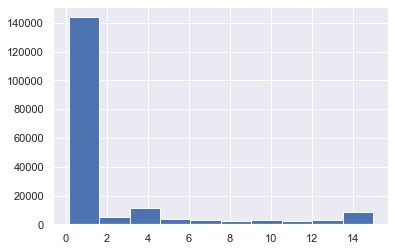

In [43]:
Cust_Account['mean_count_0_to_29_dpd'].hist()

**Our Findings:** With most values in the 0 to 1 range, it suggests that a significant portion of accounts have either made payments on time ('0') or have only experienced a very short delay ('1') within the first 29 days.

#### The total duration between last payment date and account opened date of all accounts

In [44]:
from datetime import datetime

# Convert date columns to datetime format
Cust_Account['opened_dt'] = pd.to_datetime(Cust_Account['opened_dt'], format='%d-%b-%y')
Cust_Account['last_paymt_dt'] = pd.to_datetime(Cust_Account['last_paymt_dt'], format='%d-%b-%y')

# Calculate duration between last payment date and account opened date for all accounts
Cust_Account['total_diff_lastpaymt_opened_dt'] = (Cust_Account['last_paymt_dt'] - Cust_Account['opened_dt']).dt.days


In [45]:
Cust_Account.head(3)

,dt_opened,customer_no,upload_dt,acct_type,owner_indic,opened_dt,last_paymt_dt,closed_dt,reporting_dt,high_credit_amt,cur_balance_amt,amt_past_due,paymenthistory1,paymenthistory2,paymt_str_dt,paymt_end_dt,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount,count_dpd_0_29,payment_history,mean_count_0_to_29_dpd,total_diff_lastpaymt_opened_dt
0,10-Nov-15,12265,20-Oct-15,6,1,2013-06-09,2014-06-30,05-Jul-14,30-Sep-15,20900.0,0,NaN,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",NaN,01-Sep-15,01-Jul-14,NaN,NaN,NaN,NaN,NaN,0,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",15.000000,386.0
1,10-Nov-15,12265,20-Oct-15,10,1,2012-05-25,2015-09-06,NaN,03-Oct-15,16201.0,10390,NaN,"""""""0000000000000000000000000000000000000000000...","""""""000000000000000000000000000XXX0000000000000...",01-Oct-15,01-Nov-12,14000.0,1400.0,NaN,3.0,5603.0,54,"""""""0000000000000000000000000000000000000000000...",0.284483,1199.0
2,10-Nov-15,12265,20-Oct-15,10,1,2012-03-22,2015-08-31,NaN,30-Sep-15,41028.0,34420,NaN,"""""""0000000000000000000000000000000000000000000...","""""""0000000000000000000000000000000000000000000...",01-Sep-15,01-Oct-12,NaN,NaN,NaN,NaN,NaN,54,"""""""0000000000000000000000000000000000000000000...",0.232759,1257.0


In [46]:
# Find rows where 'last_paymt_dt' is not earlier than 'opened_dt'
later_dates_mask = Cust_Account['last_paymt_dt'] >= Cust_Account['opened_dt']
filtered_data = Cust_Account[later_dates_mask]
filtered_data.head()

,dt_opened,customer_no,upload_dt,acct_type,owner_indic,opened_dt,last_paymt_dt,closed_dt,reporting_dt,high_credit_amt,cur_balance_amt,amt_past_due,paymenthistory1,paymenthistory2,paymt_str_dt,paymt_end_dt,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount,count_dpd_0_29,payment_history,mean_count_0_to_29_dpd,total_diff_lastpaymt_opened_dt
0,10-Nov-15,12265,20-Oct-15,6,1,2013-06-09,2014-06-30,05-Jul-14,30-Sep-15,20900.0,0,NaN,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",NaN,01-Sep-15,01-Jul-14,NaN,NaN,NaN,NaN,NaN,0,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",15.000000,386.0
1,10-Nov-15,12265,20-Oct-15,10,1,2012-05-25,2015-09-06,NaN,03-Oct-15,16201.0,10390,NaN,"""""""0000000000000000000000000000000000000000000...","""""""000000000000000000000000000XXX0000000000000...",01-Oct-15,01-Nov-12,14000.0,1400.0,NaN,3.0,5603.0,54,"""""""0000000000000000000000000000000000000000000...",0.284483,1199.0
2,10-Nov-15,12265,20-Oct-15,10,1,2012-03-22,2015-08-31,NaN,30-Sep-15,41028.0,34420,NaN,"""""""0000000000000000000000000000000000000000000...","""""""0000000000000000000000000000000000000000000...",01-Sep-15,01-Oct-12,NaN,NaN,NaN,NaN,NaN,54,"""""""0000000000000000000000000000000000000000000...",0.232759,1257.0
4,20-Jul-15,15606,09-Jul-15,6,1,2015-01-18,2015-05-05,NaN,31-May-15,20250.0,13500,NaN,"""""""000000000000000""""""",NaN,01-May-15,01-Jan-15,NaN,NaN,NaN,NaN,NaN,15,"""""""000000000000000""""",0.450000,107.0
5,20-Jul-15,15606,09-Jul-15,6,1,2015-01-14,2015-05-02,NaN,31-May-15,20000.0,8000,NaN,"""""""000000000000000""""""",NaN,01-May-15,01-Jan-15,NaN,NaN,NaN,NaN,NaN,15,"""""""000000000000000""""",0.450000,108.0


In [47]:
Cust_Account.drop(index=Cust_Account[~later_dates_mask].index, inplace=True)

<AxesSubplot:>

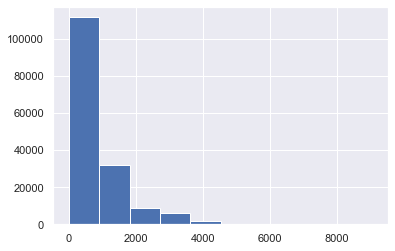

In [48]:
Cust_Account['total_diff_lastpaymt_opened_dt'].hist()

**Our Findings:** With most values in the 0 to 500 range, suggests that most of the accounts have newer liabilities. It represents accounts that were opened more recently before the last payment was made.

### The smallest number of months passed before first 30+ dpd appeared for each account.

In [49]:
# Define a function to calculate the minimum number of months passed before first 30+ dpd appeared for an account
def min_months_last_30_plus(payment_history):
    current_dpd_count = 0
    months_passed = 0
    min_months = np.inf
    for c in payment_history:
        if c == '0' or c == '1' or c == '2' or c == '3':
            current_dpd_count = 0
        else:
            current_dpd_count += 1
            if current_dpd_count >= 30:
                min_months = min(min_months, months_passed)
        months_passed += 1
    if min_months == np.inf:
        min_months = -1
    return min_months

# Apply the function to the payment history column and create a new column for the result
Cust_Account['min_months_last_30_plus'] = Cust_Account['payment_history'].apply(min_months_last_30_plus)

# Create a new column 'has_30_plus_dpd' that indicates whether the account has experienced 30+ dpd or not
Cust_Account['has_30_plus_dpd'] = (Cust_Account['min_months_last_30_plus'] >= 0).astype(int)

In [50]:
Cust_Account.head(5)

,dt_opened,customer_no,upload_dt,acct_type,owner_indic,opened_dt,last_paymt_dt,closed_dt,reporting_dt,high_credit_amt,cur_balance_amt,amt_past_due,paymenthistory1,paymenthistory2,paymt_str_dt,paymt_end_dt,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount,count_dpd_0_29,payment_history,mean_count_0_to_29_dpd,total_diff_lastpaymt_opened_dt,min_months_last_30_plus,has_30_plus_dpd
0,10-Nov-15,12265,20-Oct-15,6,1,2013-06-09,2014-06-30,05-Jul-14,30-Sep-15,20900.0,0,NaN,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",NaN,01-Sep-15,01-Jul-14,NaN,NaN,NaN,NaN,NaN,0,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",15.000000,386.0,29,1
1,10-Nov-15,12265,20-Oct-15,10,1,2012-05-25,2015-09-06,NaN,03-Oct-15,16201.0,10390,NaN,"""""""0000000000000000000000000000000000000000000...","""""""000000000000000000000000000XXX0000000000000...",01-Oct-15,01-Nov-12,14000.0,1400.0,NaN,3.0,5603.0,54,"""""""0000000000000000000000000000000000000000000...",0.284483,1199.0,-1,0
2,10-Nov-15,12265,20-Oct-15,10,1,2012-03-22,2015-08-31,NaN,30-Sep-15,41028.0,34420,NaN,"""""""0000000000000000000000000000000000000000000...","""""""0000000000000000000000000000000000000000000...",01-Sep-15,01-Oct-12,NaN,NaN,NaN,NaN,NaN,54,"""""""0000000000000000000000000000000000000000000...",0.232759,1257.0,-1,0
4,20-Jul-15,15606,09-Jul-15,6,1,2015-01-18,2015-05-05,NaN,31-May-15,20250.0,13500,NaN,"""""""000000000000000""""""",NaN,01-May-15,01-Jan-15,NaN,NaN,NaN,NaN,NaN,15,"""""""000000000000000""""",0.450000,107.0,-1,0
5,20-Jul-15,15606,09-Jul-15,6,1,2015-01-14,2015-05-02,NaN,31-May-15,20000.0,8000,NaN,"""""""000000000000000""""""",NaN,01-May-15,01-Jan-15,NaN,NaN,NaN,NaN,NaN,15,"""""""000000000000000""""",0.450000,108.0,-1,0


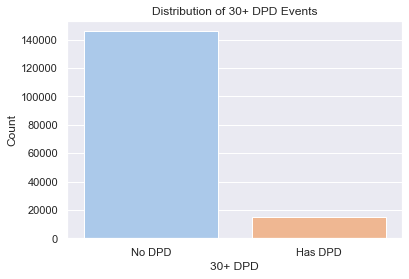

In [51]:
sns.countplot(data=Cust_Account, x='has_30_plus_dpd', palette='pastel')
plt.xticks(ticks=[0, 1], labels=['No DPD', 'Has DPD'])

plt.xlabel('30+ DPD')
plt.ylabel('Count')
plt.title('Distribution of 30+ DPD Events')

plt.show()


**Our Findings:** We find that most of the customers in our dataset has no dpd which is a good sign for the Bank

### Finding the Utilisation Trend

In [52]:
# Calculate total cur_bal_amt and credit limit for each customer
customer_totals = Cust_Account.groupby('customer_no')[['cur_balance_amt', 'creditlimit']].sum()

# Calculate mean cur_bal_amt and credit limit for each customer
customer_means = Cust_Account.groupby('customer_no')[['cur_balance_amt', 'creditlimit', 'cashlimit']].mean()

# Calculate total cur_bal_amt and credit limit across all customers
total_totals = customer_totals.sum()

# Calculate mean cur_bal_amt and credit limit across all customers
total_means = customer_means.mean()

# Calculate utilisation_trend for each customer
customer_ut = (customer_totals['cur_balance_amt'] / customer_totals['creditlimit']) / (customer_means['cur_balance_amt'] / (customer_means['creditlimit'] + customer_means['cashlimit']))

# Calculate utilisation_trend for all customers
total_ut = ((total_totals['cur_balance_amt'] / total_totals['creditlimit']) / (total_means['cur_balance_amt'] / (total_means['creditlimit'] + total_means['cashlimit'])))

# Add utilisation_trend column to the Cust_Account dataframe
Cust_Account['utilisation_trend'] = customer_ut / total_ut


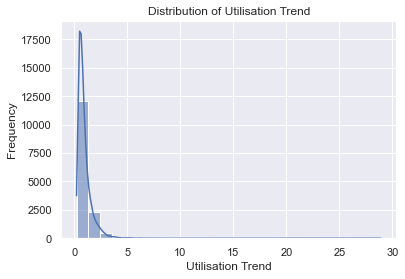

In [53]:
sns.histplot(data=Cust_Account, x='utilisation_trend', bins=26, kde=True)
plt.xlabel('Utilisation Trend')
plt.ylabel('Frequency')
plt.title('Distribution of Utilisation Trend')
plt.show()

**Our Findings:**
Most of the utilisation_trend values are between 0 to 3, it indicates that the majority of customers have a low to moderate credit utilization trend. A lower utilisation_trend value generally suggests that customers are utilizing a smaller proportion of their available credit limit, which is generally considered a positive sign. It indicates that customers are managing their credit responsibly and not excessively relying on credit.

On the other hand, higher utilisation_trend values could indicate that some customers are utilizing a significant portion of their available credit limit. This might be seen as a riskier behavior, as high credit utilization can impact credit scores and suggest a higher risk of default.

We should find out the customers who has high credit utilization because they may be at a higher risk of default.

In [54]:
# Define a function to categorize the 'utilisation_trend' values
def categorize_utilization_trend(value):
    if pd.isnull(value) or value <= 4:
        return 0  # Low Utilisation Trend
    else:
        return 1  # Higher Utilisation Trend

# Create the new categorical feature 'high_low_utilization_trend'
Cust_Account['high_low_utilization_trend'] = Cust_Account['utilisation_trend'].apply(categorize_utilization_trend)

Cust_Account.head()

,dt_opened,customer_no,upload_dt,acct_type,owner_indic,opened_dt,last_paymt_dt,closed_dt,reporting_dt,high_credit_amt,cur_balance_amt,amt_past_due,paymenthistory1,paymenthistory2,paymt_str_dt,paymt_end_dt,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount,count_dpd_0_29,payment_history,mean_count_0_to_29_dpd,total_diff_lastpaymt_opened_dt,min_months_last_30_plus,has_30_plus_dpd,utilisation_trend,high_low_utilization_trend
0,10-Nov-15,12265,20-Oct-15,6,1,2013-06-09,2014-06-30,05-Jul-14,30-Sep-15,20900.0,0,NaN,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",NaN,01-Sep-15,01-Jul-14,NaN,NaN,NaN,NaN,NaN,0,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",15.000000,386.0,29,1,NaN,0
1,10-Nov-15,12265,20-Oct-15,10,1,2012-05-25,2015-09-06,NaN,03-Oct-15,16201.0,10390,NaN,"""""""0000000000000000000000000000000000000000000...","""""""000000000000000000000000000XXX0000000000000...",01-Oct-15,01-Nov-12,14000.0,1400.0,NaN,3.0,5603.0,54,"""""""0000000000000000000000000000000000000000000...",0.284483,1199.0,-1,0,1.518118,0
2,10-Nov-15,12265,20-Oct-15,10,1,2012-03-22,2015-08-31,NaN,30-Sep-15,41028.0,34420,NaN,"""""""0000000000000000000000000000000000000000000...","""""""0000000000000000000000000000000000000000000...",01-Sep-15,01-Oct-12,NaN,NaN,NaN,NaN,NaN,54,"""""""0000000000000000000000000000000000000000000...",0.232759,1257.0,-1,0,0.404429,0
4,20-Jul-15,15606,09-Jul-15,6,1,2015-01-18,2015-05-05,NaN,31-May-15,20250.0,13500,NaN,"""""""000000000000000""""""",NaN,01-May-15,01-Jan-15,NaN,NaN,NaN,NaN,NaN,15,"""""""000000000000000""""",0.450000,107.0,-1,0,1.300011,0
5,20-Jul-15,15606,09-Jul-15,6,1,2015-01-14,2015-05-02,NaN,31-May-15,20000.0,8000,NaN,"""""""000000000000000""""""",NaN,01-May-15,01-Jan-15,NaN,NaN,NaN,NaN,NaN,15,"""""""000000000000000""""",0.450000,108.0,-1,0,NaN,0


In [55]:
Cust_Account["high_low_utilization_trend"].value_counts()

0    160597
1        75
Name: high_low_utilization_trend, dtype: int64

### Finding the Ratio of Current Balance and Credit Limit

In [56]:
Cust_Account['Ratio_currbalance_creditlimit'] = Cust_Account['cur_balance_amt'] / Cust_Account['creditlimit']

In [57]:
Cust_Account

,dt_opened,customer_no,upload_dt,acct_type,owner_indic,opened_dt,last_paymt_dt,closed_dt,reporting_dt,high_credit_amt,cur_balance_amt,amt_past_due,paymenthistory1,paymenthistory2,paymt_str_dt,paymt_end_dt,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount,count_dpd_0_29,payment_history,mean_count_0_to_29_dpd,total_diff_lastpaymt_opened_dt,min_months_last_30_plus,has_30_plus_dpd,utilisation_trend,high_low_utilization_trend,Ratio_currbalance_creditlimit
0,10-Nov-15,12265,20-Oct-15,6,1,2013-06-09,2014-06-30,05-Jul-14,30-Sep-15,20900.0,0,NaN,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",NaN,01-Sep-15,01-Jul-14,NaN,NaN,NaN,NaN,NaN,0,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",15.000000,386.0,29,1,NaN,0,NaN
1,10-Nov-15,12265,20-Oct-15,10,1,2012-05-25,2015-09-06,NaN,03-Oct-15,16201.0,10390,NaN,"""""""0000000000000000000000000000000000000000000...","""""""000000000000000000000000000XXX0000000000000...",01-Oct-15,01-Nov-12,14000.0,1400.0,NaN,3.0,5603.0,54,"""""""0000000000000000000000000000000000000000000...",0.284483,1199.0,-1,0,1.518118,0,0.742143
2,10-Nov-15,12265,20-Oct-15,10,1,2012-03-22,2015-08-31,NaN,30-Sep-15,41028.0,34420,NaN,"""""""0000000000000000000000000000000000000000000...","""""""0000000000000000000000000000000000000000000...",01-Sep-15,01-Oct-12,NaN,NaN,NaN,NaN,NaN,54,"""""""0000000000000000000000000000000000000000000...",0.232759,1257.0,-1,0,0.404429,0,NaN
4,20-Jul-15,15606,09-Jul-15,6,1,2015-01-18,2015-05-05,NaN,31-May-15,20250.0,13500,NaN,"""""""000000000000000""""""",NaN,01-May-15,01-Jan-15,NaN,NaN,NaN,NaN,NaN,15,"""""""000000000000000""""",0.450000,107.0,-1,0,1.300011,0,NaN
5,20-Jul-15,15606,09-Jul-15,6,1,2015-01-14,2015-05-02,NaN,31-May-15,20000.0,8000,NaN,"""""""000000000000000""""""",NaN,01-May-15,01-Jan-15,NaN,NaN,NaN,NaN,NaN,15,"""""""000000000000000""""",0.450000,108.0,-1,0,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186321,11-Jun-15,1611,25-May-15,5,1,2008-04-29,2011-07-30,30-Jul-11,31-Jul-11,130000.0,0,NaN,"""""""0000600600600900600600300300000000000300300...","""""""0000000000000000000000000000000000000000000...",01-Jul-11,01-Aug-08,NaN,NaN,NaN,NaN,NaN,48,"""""""0000600600600900600600300300000000000300300...",0.362069,1187.0,-1,0,NaN,0,NaN
186322,11-Jun-15,1611,25-May-15,5,1,2007-10-08,2010-11-20,20-Nov-10,30-Nov-10,75000.0,0,NaN,"""""""0000230230550540230000000000000000000000000...","""""""000000000000000000STDSTDSTDSTDSTDSTDSTDSTD""""""",01-Nov-10,01-Apr-08,NaN,NaN,NaN,NaN,NaN,50,"""""""0000230230550540230000000000000000000000000...",2.971154,1139.0,-1,0,NaN,0,NaN
186323,11-Jun-15,1611,25-May-15,10,1,2007-05-30,2012-09-05,23-Sep-12,28-Feb-14,29516.0,0,NaN,"""""""0001300990690380000000000000000000370000000...","""""""0000000000000000000000000000000000000000000...",01-Sep-12,01-Oct-09,NaN,NaN,NaN,NaN,NaN,48,"""""""0001300990690380000000000000000000370000000...",0.327586,1925.0,-1,0,NaN,0,NaN
186324,11-Jun-15,1611,25-May-15,10,1,2007-05-02,2015-04-21,NaN,30-Apr-15,24228.0,24228,NaN,"""""""0000000000000000000000000000000000000000000...","""""""0000000000000000000000000000000000000000000...",01-Apr-15,01-May-12,NaN,NaN,NaN,NaN,NaN,54,"""""""0000000000000000000000000000000000000000000...",0.232759,2911.0,-1,0,NaN,0,NaN


In [58]:
Cust_Account[Cust_Account["customer_no"] ==12265 ]

,dt_opened,customer_no,upload_dt,acct_type,owner_indic,opened_dt,last_paymt_dt,closed_dt,reporting_dt,high_credit_amt,cur_balance_amt,amt_past_due,paymenthistory1,paymenthistory2,paymt_str_dt,paymt_end_dt,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount,count_dpd_0_29,payment_history,mean_count_0_to_29_dpd,total_diff_lastpaymt_opened_dt,min_months_last_30_plus,has_30_plus_dpd,utilisation_trend,high_low_utilization_trend,Ratio_currbalance_creditlimit
0,10-Nov-15,12265,20-Oct-15,6,1,2013-06-09,2014-06-30,05-Jul-14,30-Sep-15,20900.0,0,NaN,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",NaN,01-Sep-15,01-Jul-14,NaN,NaN,NaN,NaN,NaN,0,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",15.000000,386.0,29,1,NaN,0,NaN
1,10-Nov-15,12265,20-Oct-15,10,1,2012-05-25,2015-09-06,NaN,03-Oct-15,16201.0,10390,NaN,"""""""0000000000000000000000000000000000000000000...","""""""000000000000000000000000000XXX0000000000000...",01-Oct-15,01-Nov-12,14000.0,1400.0,NaN,3.0,5603.0,54,"""""""0000000000000000000000000000000000000000000...",0.284483,1199.0,-1,0,1.518118,0,0.742143
2,10-Nov-15,12265,20-Oct-15,10,1,2012-03-22,2015-08-31,NaN,30-Sep-15,41028.0,34420,NaN,"""""""0000000000000000000000000000000000000000000...","""""""0000000000000000000000000000000000000000000...",01-Sep-15,01-Oct-12,NaN,NaN,NaN,NaN,NaN,54,"""""""0000000000000000000000000000000000000000000...",0.232759,1257.0,-1,0,0.404429,0,NaN


### Processing Customer Account Data Table

In [59]:
cols = ['customer_no','high_credit_amt', 'cur_balance_amt', 'amt_past_due', 'creditlimit','cashlimit',
       'acct_type','owner_indic','rateofinterest','paymentfrequency','actualpaymentamount','mean_count_0_to_29_dpd',
       'total_diff_lastpaymt_opened_dt','min_months_last_30_plus','utilisation_trend','Ratio_currbalance_creditlimit',
        'payment_history','count_dpd_0_29','has_30_plus_dpd','high_low_utilization_trend']

In [60]:
df_account = Cust_Account[cols]

In [61]:
df_account.head()

,customer_no,high_credit_amt,cur_balance_amt,amt_past_due,creditlimit,cashlimit,acct_type,owner_indic,rateofinterest,paymentfrequency,actualpaymentamount,mean_count_0_to_29_dpd,total_diff_lastpaymt_opened_dt,min_months_last_30_plus,utilisation_trend,Ratio_currbalance_creditlimit,payment_history,count_dpd_0_29,has_30_plus_dpd,high_low_utilization_trend
0,12265,20900.0,0,NaN,NaN,NaN,6,1,NaN,NaN,NaN,15.000000,386.0,29,NaN,NaN,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",0,1,0
1,12265,16201.0,10390,NaN,14000.0,1400.0,10,1,NaN,3.0,5603.0,0.284483,1199.0,-1,1.518118,0.742143,"""""""0000000000000000000000000000000000000000000...",54,0,0
2,12265,41028.0,34420,NaN,NaN,NaN,10,1,NaN,NaN,NaN,0.232759,1257.0,-1,0.404429,NaN,"""""""0000000000000000000000000000000000000000000...",54,0,0
4,15606,20250.0,13500,NaN,NaN,NaN,6,1,NaN,NaN,NaN,0.450000,107.0,-1,1.300011,NaN,"""""""000000000000000""""",15,0,0
5,15606,20000.0,8000,NaN,NaN,NaN,6,1,NaN,NaN,NaN,0.450000,108.0,-1,NaN,NaN,"""""""000000000000000""""",15,0,0


In [62]:
df_account['acct_type'] = df_account['acct_type'].astype(str)
df_account['owner_indic'] = df_account['owner_indic'].astype(str)
df_account['count_dpd_0_29'] = df_account['count_dpd_0_29'].astype(str)
df_account['has_30_plus_dpd'] = df_account['has_30_plus_dpd'].astype(str)
df_account['high_low_utilization_trend'] = df_account['high_low_utilization_trend'].astype(str)

df_account['rateofinterest'] = pd.to_numeric(df_account['rateofinterest'], errors='coerce')
df_account['rateofinterest'] = df_account['rateofinterest'].astype('float64')


In [63]:
df_account.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160672 entries, 0 to 186325
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   customer_no                     160672 non-null  int64  
 1   high_credit_amt                 157665 non-null  float64
 2   cur_balance_amt                 160672 non-null  int64  
 3   amt_past_due                    663 non-null     float64
 4   creditlimit                     43562 non-null   float64
 5   cashlimit                       31905 non-null   float64
 6   acct_type                       160672 non-null  object 
 7   owner_indic                     160672 non-null  object 
 8   rateofinterest                  20133 non-null   float64
 9   paymentfrequency                54878 non-null   float64
 10  actualpaymentamount             40358 non-null   float64
 11  mean_count_0_to_29_dpd          160672 non-null  float64
 12  total_diff_lastp

In [64]:
import pandas as pd

# Replace NaN in numerical columns with mean
numerical_cols = df_account.select_dtypes(include=['float64', 'int64']).columns
df_account[numerical_cols] = df_account[numerical_cols].fillna(df_account[numerical_cols].mean())

# Replace NaN in categorical columns with mode
categorical_cols = df_account.select_dtypes(include=['object']).columns
df_account[categorical_cols] = df_account[categorical_cols].fillna(df_account[categorical_cols].mode().iloc[0])



In [65]:
df_account.drop_duplicates(subset='customer_no', keep='first', inplace=True)

In [66]:
df_account.shape

(23845, 20)

In [67]:
df_account.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23845 entries, 0 to 186317
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_no                     23845 non-null  int64  
 1   high_credit_amt                 23845 non-null  float64
 2   cur_balance_amt                 23845 non-null  int64  
 3   amt_past_due                    23845 non-null  float64
 4   creditlimit                     23845 non-null  float64
 5   cashlimit                       23845 non-null  float64
 6   acct_type                       23845 non-null  object 
 7   owner_indic                     23845 non-null  object 
 8   rateofinterest                  23845 non-null  float64
 9   paymentfrequency                23845 non-null  float64
 10  actualpaymentamount             23845 non-null  float64
 11  mean_count_0_to_29_dpd          23845 non-null  float64
 12  total_diff_lastpaymt_opened_dt 

In [68]:
df_account.to_csv("df_account.csv")

## Customer Enquiry Data

In [69]:
Cust_Enquiry = pd.read_sql("SELECT * FROM Cust_Enquiry", con=db)
Cust_Enquiry.to_csv("Cust_Enquiry.csv")

In [70]:
Cust_Enquiry = pd.read_csv("Cust_Enquiry.csv").drop(["Unnamed: 0"],axis =1)

Cust_Enquiry.head()

,dt_opened,customer_no,upload_dt,enquiry_dt,enq_purpose,enq_amt
0,18-Apr-15,1,21-Apr-15,19-Dec-14,2.0,3500000.0
1,18-Apr-15,1,21-Apr-15,05-Mar-14,5.0,500000.0
2,18-Apr-15,1,21-Apr-15,05-Mar-14,0.0,50000.0
3,18-Apr-15,1,21-Apr-15,22-Feb-14,10.0,50000.0
4,18-Apr-15,1,21-Apr-15,11-Jun-13,10.0,1000.0


### Processing Customer Enquiry Table

We will pre-process the customer enquiry table first as there are multiple enquiries by customer and we need to make the information in the table aggregated before joining with the other tables

In [71]:
df_enquiry = Cust_Enquiry

In [72]:
df_enquiry['enq_purpose'] = df_enquiry['enq_purpose'].astype(str)

In [73]:
df_enquiry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413188 entries, 0 to 413187
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt_opened    413188 non-null  object 
 1   customer_no  413188 non-null  int64  
 2   upload_dt    413078 non-null  object 
 3   enquiry_dt   413078 non-null  object 
 4   enq_purpose  413188 non-null  object 
 5   enq_amt      413078 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 18.9+ MB


In [74]:
# Replace NaN in numerical columns with mean
numerical_cols = df_enquiry.select_dtypes(include=['float64', 'int64']).columns
df_enquiry[numerical_cols] = df_enquiry[numerical_cols].fillna(df_enquiry[numerical_cols].mean())

# Replace NaN in categorical columns with mode
categorical_cols = df_enquiry.select_dtypes(include=['object']).columns
df_enquiry[categorical_cols] = df_enquiry[categorical_cols].fillna(df_enquiry[categorical_cols].mode().iloc[0])

### Finding total enquiry amount, enquiry frequency and enquiry count

In [75]:
# Creating a new DataFrame with the total amount of enquiries per customer
df_total_enquiries = df_enquiry.groupby('customer_no')['enq_amt'].sum().reset_index()
df_total_enquiries.columns = ['customer_no', 'total_enq_amt']

# Creating a new DataFrame with the frequency of enquiries per customer
df_enquiry['enq_date'] = pd.to_datetime(df_enquiry['enquiry_dt'])  # Convert date string to datetime object
df_enquiry['enq_month'] = df_enquiry['enq_date'].dt.to_period('M')  # Extract month from date
df_enquiry_freq = df_enquiry.groupby(['customer_no', 'enq_month']).size().reset_index(name='enq_count')
df_enquiry_freq['enq_freq'] = df_enquiry_freq['enq_count'] / df_enquiry_freq.groupby('customer_no')['enq_count'].transform('sum')
df_enquiry_freq = df_enquiry_freq.groupby('customer_no')['enq_freq'].mean().reset_index()

# Merging the new DataFrames with the original DataFrame
df_enquiry = pd.merge(df_enquiry, df_total_enquiries, on='customer_no')
df_enquiry = pd.merge(df_enquiry, df_enquiry_freq, on='customer_no')

# Enquiry count
df_enquiry_freq = df_enquiry.groupby(['customer_no', 'enq_month']).size().reset_index(name='enq_count')
enquiry_count = df_enquiry.groupby('customer_no').size().reset_index(name='enquiry_count')

# Merging the count DataFrame with the original DataFrame
df_enquiry = pd.merge(df_enquiry, enquiry_count, on='customer_no')
df_enquiry

,dt_opened,customer_no,upload_dt,enquiry_dt,enq_purpose,enq_amt,enq_date,enq_month,total_enq_amt,enq_freq,enquiry_count
0,18-Apr-15,1,21-Apr-15,19-Dec-14,2.0,3500000.0,2014-12-19,2014-12,4981150.0,0.066667,18
1,18-Apr-15,1,21-Apr-15,05-Mar-14,5.0,500000.0,2014-03-05,2014-03,4981150.0,0.066667,18
2,18-Apr-15,1,21-Apr-15,05-Mar-14,0.0,50000.0,2014-03-05,2014-03,4981150.0,0.066667,18
3,18-Apr-15,1,21-Apr-15,22-Feb-14,10.0,50000.0,2014-02-22,2014-02,4981150.0,0.066667,18
4,18-Apr-15,1,21-Apr-15,11-Jun-13,10.0,1000.0,2013-06-11,2013-06,4981150.0,0.066667,18
...,...,...,...,...,...,...,...,...,...,...,...
413183,04-Dec-15,23896,09-Nov-15,22-Oct-11,5.0,200000.0,2011-10-22,2011-10,11402001.0,0.076923,16
413184,04-Dec-15,23896,09-Nov-15,06-Jan-11,10.0,50000.0,2011-01-06,2011-01,11402001.0,0.076923,16
413185,04-Dec-15,23896,09-Nov-15,01-Apr-10,10.0,50000.0,2010-04-01,2010-04,11402001.0,0.076923,16
413186,04-Dec-15,23896,09-Nov-15,21-Feb-10,1.0,330000.0,2010-02-21,2010-02,11402001.0,0.076923,16


### Number of enquiry made in past 365 days

In [76]:
from datetime import datetime, timedelta

# Convert the enquiry_date column to datetime format
df_enquiry['enquiry_dt'] = pd.to_datetime(df_enquiry['enquiry_dt'])

# Get the date 365 days ago from the latest enquiry date
end_date = df_enquiry['enquiry_dt'].max()
start_date = end_date - timedelta(days=365)

# Filter the dataframe to keep only enquiries made in the past 365 days
df_enquiry_365 = df_enquiry[(df_enquiry['enquiry_dt'] >= start_date) & (df_enquiry['enquiry_dt'] <= end_date)]

# Count the number of enquiries in the past 365 days and create a new column
df_enquiry['count_enquiry_recency_365'] = df_enquiry_365.groupby('customer_no')['enquiry_dt'].transform('count')


In [77]:
df_enquiry['count_enquiry_recency_365'].value_counts()

4.0     8708
3.0     8685
5.0     8005
2.0     7518
6.0     7458
7.0     6223
8.0     5328
9.0     4572
1.0     4547
10.0    3820
11.0    3135
12.0    2580
13.0    1950
14.0    1610
15.0    1425
16.0    1088
20.0     900
17.0     884
18.0     846
19.0     779
21.0     546
22.0     396
24.0     360
23.0     345
27.0     189
31.0     186
25.0     125
28.0     112
36.0     108
26.0     104
33.0      99
29.0      87
40.0      80
39.0      78
60.0      60
30.0      60
58.0      58
48.0      48
46.0      46
44.0      44
43.0      43
38.0      38
37.0      37
34.0      34
32.0      32
Name: count_enquiry_recency_365, dtype: int64

### Finding most frequent enquiry purpose

In [78]:
most_frequent_purpose = df_enquiry.groupby('customer_no')['enq_purpose'].apply(lambda x: x.value_counts().index[0]).reset_index(name='most_frequent_purpose')
df_enquiry = pd.merge(df_enquiry, most_frequent_purpose, on='customer_no')
df_enquiry

,dt_opened,customer_no,upload_dt,enquiry_dt,enq_purpose,enq_amt,enq_date,enq_month,total_enq_amt,enq_freq,enquiry_count,count_enquiry_recency_365,most_frequent_purpose
0,18-Apr-15,1,21-Apr-15,2014-12-19,2.0,3500000.0,2014-12-19,2014-12,4981150.0,0.066667,18,NaN,10.0
1,18-Apr-15,1,21-Apr-15,2014-03-05,5.0,500000.0,2014-03-05,2014-03,4981150.0,0.066667,18,NaN,10.0
2,18-Apr-15,1,21-Apr-15,2014-03-05,0.0,50000.0,2014-03-05,2014-03,4981150.0,0.066667,18,NaN,10.0
3,18-Apr-15,1,21-Apr-15,2014-02-22,10.0,50000.0,2014-02-22,2014-02,4981150.0,0.066667,18,NaN,10.0
4,18-Apr-15,1,21-Apr-15,2013-06-11,10.0,1000.0,2013-06-11,2013-06,4981150.0,0.066667,18,NaN,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413183,04-Dec-15,23896,09-Nov-15,2011-10-22,5.0,200000.0,2011-10-22,2011-10,11402001.0,0.076923,16,NaN,10.0
413184,04-Dec-15,23896,09-Nov-15,2011-01-06,10.0,50000.0,2011-01-06,2011-01,11402001.0,0.076923,16,NaN,10.0
413185,04-Dec-15,23896,09-Nov-15,2010-04-01,10.0,50000.0,2010-04-01,2010-04,11402001.0,0.076923,16,NaN,10.0
413186,04-Dec-15,23896,09-Nov-15,2010-02-21,1.0,330000.0,2010-02-21,2010-02,11402001.0,0.076923,16,NaN,10.0


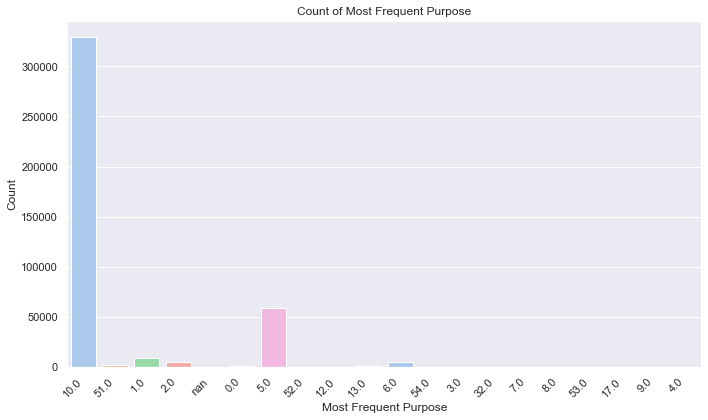

In [79]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_enquiry, x='most_frequent_purpose', palette='pastel')

plt.xlabel('Most Frequent Purpose')
plt.ylabel('Count')
plt.title('Count of Most Frequent Purpose')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Number of enquiry made in past 90 days

In [80]:
from datetime import datetime, timedelta

# Convert the enquiry_date column to datetime format
df_enquiry['enquiry_dt'] = pd.to_datetime(df_enquiry['enquiry_dt'])

# Get the date 90 days ago from the latest enquiry date
end_date = df_enquiry['enquiry_dt'].max()
start_date = end_date - timedelta(days=90)

# Filter the dataframe to keep only enquiries made in the past 365 days
df_enquiry_90 = df_enquiry[(df_enquiry['enquiry_dt'] >= start_date) & (df_enquiry['enquiry_dt'] <= end_date)]

# Count the number of enquiries in the past 365 days and create a new column
df_enquiry['count_enquiry_recency_90'] = df_enquiry_90.groupby('customer_no')['enquiry_dt'].transform('count')

In [81]:
df_enquiry['count_enquiry_recency_90'].value_counts()

1.0     1855
2.0     1516
3.0      987
4.0      588
5.0      410
6.0      246
7.0      119
8.0       72
11.0      55
9.0       54
10.0      20
20.0      20
18.0      18
15.0      15
14.0      14
13.0      13
Name: count_enquiry_recency_90, dtype: int64

### Average difference between enquiry date opened and enquiry date

In [82]:
# Convert date columns to datetime format
df_enquiry['dt_opened'] = pd.to_datetime(df_enquiry['dt_opened'], format='%d-%b-%y')
df_enquiry['enquiry_dt'] = pd.to_datetime(df_enquiry['enquiry_dt'], format='%Y-%m-%d')

# Calculate the difference between the two dates and convert to number of days
df_enquiry['enq_dt_diff'] = (df_enquiry['dt_opened'] - df_enquiry['enquiry_dt']).dt.days

# Calculate the mean of the differences for each customer
enq_dt_diff_mean = df_enquiry.groupby('customer_no')['enq_dt_diff'].mean().reset_index()
enq_dt_diff_mean.columns = ['customer_no', 'mean_enq_dt_diff']
df_enquiry = pd.merge(df_enquiry, enq_dt_diff_mean, on='customer_no')

We will drop columns whose information was already aggregated in a separate field

In [83]:
df_enquiry = df_enquiry.drop(columns=["enquiry_dt","enq_date","enq_month",'upload_dt','dt_opened'],axis=1)

In [84]:
df_enquiry.head()

,customer_no,enq_purpose,enq_amt,total_enq_amt,enq_freq,enquiry_count,count_enquiry_recency_365,most_frequent_purpose,count_enquiry_recency_90,enq_dt_diff,mean_enq_dt_diff
0,1,2.0,3500000.0,4981150.0,0.066667,18,NaN,10.0,NaN,120,1443.5
1,1,5.0,500000.0,4981150.0,0.066667,18,NaN,10.0,NaN,409,1443.5
2,1,0.0,50000.0,4981150.0,0.066667,18,NaN,10.0,NaN,409,1443.5
3,1,10.0,50000.0,4981150.0,0.066667,18,NaN,10.0,NaN,420,1443.5
4,1,10.0,1000.0,4981150.0,0.066667,18,NaN,10.0,NaN,676,1443.5


In [85]:
df_enquiry.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 413188 entries, 0 to 413187
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   customer_no                413188 non-null  int64  
 1   enq_purpose                413188 non-null  object 
 2   enq_amt                    413188 non-null  float64
 3   total_enq_amt              413188 non-null  float64
 4   enq_freq                   413188 non-null  float64
 5   enquiry_count              413188 non-null  int64  
 6   count_enquiry_recency_365  83376 non-null   float64
 7   most_frequent_purpose      413188 non-null  object 
 8   count_enquiry_recency_90   6002 non-null    float64
 9   enq_dt_diff                413188 non-null  int64  
 10  mean_enq_dt_diff           413188 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 37.8+ MB


In [86]:
df_enquiry['enquiry_count'] = df_enquiry['enquiry_count'].astype(str)
df_enquiry['count_enquiry_recency_365'] = df_enquiry['count_enquiry_recency_365'].astype(str)
df_enquiry['most_frequent_purpose'] = df_enquiry['most_frequent_purpose'].astype(str)
df_enquiry['count_enquiry_recency_90'] = df_enquiry['count_enquiry_recency_90'].astype(str)


We will drop duplicated fields

In [87]:
df_enquiry.duplicated().sum()

13827

In [88]:
df_enquiry.drop_duplicates(subset='customer_no', keep='first', inplace=True)

In [89]:
df_enquiry.shape

(23896, 11)

In [90]:
import pandas as pd

# Replace NaN in numerical columns with mean
numerical_cols = df_enquiry.select_dtypes(include=['float64', 'int64']).columns
df_enquiry[numerical_cols] = df_enquiry[numerical_cols].fillna(df_enquiry[numerical_cols].mean())

# Replace NaN in categorical columns with mode
categorical_cols = df_enquiry.select_dtypes(include=['object']).columns
df_enquiry[categorical_cols] = df_enquiry[categorical_cols].fillna(df_enquiry[categorical_cols].mode().iloc[0])

In [91]:
df_enquiry.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23896 entries, 0 to 413172
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_no                23896 non-null  int64  
 1   enq_purpose                23896 non-null  object 
 2   enq_amt                    23896 non-null  float64
 3   total_enq_amt              23896 non-null  float64
 4   enq_freq                   23896 non-null  float64
 5   enquiry_count              23896 non-null  object 
 6   count_enquiry_recency_365  23896 non-null  object 
 7   most_frequent_purpose      23896 non-null  object 
 8   count_enquiry_recency_90   23896 non-null  object 
 9   enq_dt_diff                23896 non-null  int64  
 10  mean_enq_dt_diff           23896 non-null  float64
dtypes: float64(4), int64(2), object(5)
memory usage: 2.2+ MB


In [92]:
df_enquiry.head()

,customer_no,enq_purpose,enq_amt,total_enq_amt,enq_freq,enquiry_count,count_enquiry_recency_365,most_frequent_purpose,count_enquiry_recency_90,enq_dt_diff,mean_enq_dt_diff
0,1,2.0,3500000.0,4.981150e+06,0.066667,18,nan,10.0,nan,120,1443.500000
18,2,0.0,200000000.0,6.676682e+09,0.026316,68,3.0,51.0,nan,69,812.485294
86,3,1.0,3400000.0,3.400000e+06,1.000000,1,nan,1.0,nan,438,438.000000
87,4,1.0,1800000.0,5.081000e+07,0.055556,34,nan,51.0,nan,418,1920.823529
121,5,10.0,1000.0,2.000000e+03,0.500000,2,nan,10.0,nan,1134,1497.500000


In [93]:
df_enquiry.to_csv('df_enquiry.csv')

### Demographics Data

In [94]:
Cust_Demographics = pd.read_sql("SELECT * FROM Cust_Demographics", con=db)
Cust_Demographics.to_csv("Cust_Demographics.csv")

In [95]:
Cust_Demographics = pd.read_csv("Cust_Demographics.csv").drop(["Unnamed: 0"],axis =1)

Cust_Demographics.head()

,dt_opened,customer_no,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label
0,18-Apr-15,1,13-Apr-15,Insignia,13-Apr-15,650.0,2.0,Card Setup,14.0,500000.0,NaN,NaN,NaN,Y,IS1,NaN,0.0,159,4284,4284,NaN,1.0,ADFPNXXXXX,03-Sep-65,98332XXXXX,N,@REDIFFMAIL.COM,1.0,2.0,NaN,Mumbai / Navi Mumbai / Thane,400610.0,1965.0,0.0,Self,Y,2.0,90000.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Mumbai,400059.0,@CODOGNOTTO.NET,PAN Card,ADFPNXXXXX,The Ratnakar Bank Ltd.,NaN,Y,State Bank of India,0.0,01-Jun-13,17-Jun-16,1.0,21.0,NaN,Y,Y,N,NaN,Y,1965-0,21.0,15.0,400610.0,0.0,2.0,90000.0,Nov-00,21.0,R,NaN,NaN,0000-00-00,0.0,98332XXXXX,1.0,N,0
1,21-Apr-15,2,21-Apr-15,Insignia,21-Apr-15,760.0,1.0,Card Setup,14.0,1200000.0,NaN,NaN,NaN,Y,IS1,NaN,0.0,91,B001,4077,NaN,1.0,AJWPRXXXXX,14-Jul-62,99455XXXXX,N,@GMAIL.COM,1.0,2.0,NaN,Bengaluru,560042.0,1969.0,0.0,Self,Y,2.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Bangalore,560042.0,NaN,PAN Card,AJWPRXXXXX,The Ratnakar Bank Ltd.,NaN,N,NaN,0.0,NaN,17-Jun-16,1.0,17.0,NaN,Y,Y,N,NaN,Y,1969-0,17.0,12.0,560042.0,0.0,2.0,1.0,Nov-00,17.0,R,NaN,NaN,0000-00-00,0.0,99455XXXXX,1.0,N,0
2,22-Apr-15,3,21-Apr-15,Insignia,21-Apr-15,774.0,1.0,Card Setup,14.0,700000.0,NaN,NaN,NaN,Y,IS1,NaN,0.0,91,B001,4077,NaN,2.0,AFAPNXXXXX,10-Apr-66,98456XXXXX,N,@SHOBANARAYAN.COM,1.0,0.0,NaN,Bengaluru,560042.0,1966.0,0.0,Self,Y,2.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Bangalore,560042.0,NaN,PAN Card,AFAPNXXXXX,NaN,NaN,N,NaN,0.0,NaN,17-Jun-16,3.0,17.0,NaN,N,Y,N,NaN,Y,1966-0,17.0,12.0,560042.0,0.0,2.0,1.0,Nov-00,17.0,R,NaN,NaN,0000-00-00,0.0,98456XXXXX,1.0,N,0
3,25-Apr-15,4,15-Apr-15,Insignia,20-Apr-15,770.0,1.0,Card Setup,14.0,500000.0,NaN,NaN,NaN,Y,IS1,NaN,0.0,157,5107,5107,NaN,1.0,AAAPDXXXXX,16-Apr-64,98220XXXXX,N,@VSNL.COM,1.0,3.0,NaN,Pune,411001.0,1988.0,0.0,Self,Y,2.0,100000.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Pune,411026.0,@ALBAJ.COM,PAN Card,AAAPDXXXXX,The Ratnakar Bank Ltd.,NaN,Y,HDFC Bank,0.0,NaN,17-Jun-16,1.0,21.0,NaN,Y,Y,N,NaN,Y,1988-0,21.0,16.0,411001.0,0.0,2.0,100000.0,Nov-00,21.0,R,NaN,NaN,6/15/65,1.0,98220XXXXX,1.0,N,0
4,06-May-15,5,30-Apr-15,Insignia,NaN,NaN,3.0,Card Setup,14.0,500000.0,NaN,NaN,NaN,Y,IS1,NaN,0.0,100,D016,4564,NaN,1.0,ABEPSXXXXX,03-Jan-54,98111XXXXX,N,@REDIFFMAIL.COM,1.0,3.0,NaN,Gurgaon,122009.0,1995.0,0.0,Self,Y,2.0,300000.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Gurgaon,122009.0,NaN,PAN Card,ABEPSXXXXX,The Ratnakar Bank Ltd.,NaN,N,NaN,0.0,NaN,17-Jun-16,1.0,13.0,NaN,Y,Y,N,NaN,Y,1995-0,13.0,3.0,122009.0,0.0,2.0,300000.0,Nov-00,13.0,R,NaN,NaN,0000-00-00,0.0,98111XXXXX,1.0,N,0


In [96]:
df_demographics = Cust_Demographics

In [97]:
df_demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23896 entries, 0 to 23895
Data columns (total 83 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dt_opened    23896 non-null  object 
 1   customer_no  23896 non-null  int64  
 2   entry_time   23881 non-null  object 
 3   feature_1    23881 non-null  object 
 4   feature_2    21060 non-null  object 
 5   feature_3    21060 non-null  float64
 6   feature_4    23881 non-null  float64
 7   feature_5    23881 non-null  object 
 8   feature_6    23881 non-null  float64
 9   feature_7    23881 non-null  float64
 10  feature_8    1261 non-null   object 
 11  feature_9    1261 non-null   object 
 12  feature_10   51 non-null     object 
 13  feature_11   23881 non-null  object 
 14  feature_12   23881 non-null  object 
 15  feature_13   10892 non-null  object 
 16  feature_14   16163 non-null  float64
 17  feature_15   23873 non-null  object 
 18  feature_16   23869 non-null  object 
 19  feat

### Handling Missing Values for Demographics Data

**We will create a reusable function to show us the missing values in a dataframe**

In [98]:
def find_missing(dataframe):
    missing_data_cols = dataframe.columns[dataframe.isnull().sum() > 0]
    null = dataframe.isnull().sum()
    null_df = pd.DataFrame(null,columns=["No_of_null_values"])
    null_df = null_df.loc[missing_data_cols]
    percet_missing = round(null_df["No_of_null_values"] / dataframe.shape[0] * 100, 2)
    null_df["Percentage_Missing"] = percet_missing
    if len(null_df) > 0:
        return null_df
    else:
        return "There are no null values!"


In [99]:
missing_df = find_missing(df_demographics)
missing_df = missing_df.sort_values(ascending=False,by = 'No_of_null_values')
missing_df

,No_of_null_values,Percentage_Missing
feature_61,23887,99.96
feature_74,23879,99.93
feature_18,23878,99.92
feature_10,23845,99.79
feature_49,23792,99.56
feature_17,22869,95.70
feature_8,22635,94.72
feature_9,22635,94.72
feature_57,21503,89.99
feature_73,20951,87.68


In [100]:
missing_df = missing_df[missing_df["Percentage_Missing"]>40]
missing_df

,No_of_null_values,Percentage_Missing
feature_61,23887,99.96
feature_74,23879,99.93
feature_18,23878,99.92
feature_10,23845,99.79
feature_49,23792,99.56
feature_17,22869,95.70
feature_8,22635,94.72
feature_9,22635,94.72
feature_57,21503,89.99
feature_73,20951,87.68


In [101]:
drop_feat = ['feature_61','feature_74','feature_9','feature_45','feature_53']

In [102]:
for i in drop_feat:
    if i in missing_df.index:
        df_demographics.drop(i,inplace =True,axis =1)


In [103]:
missing_df_index = missing_df.index

In [104]:
missing_df_index = [feature for feature in missing_df_index if feature not in drop_feat]

In [105]:
missing_df_index

['feature_18',
 'feature_10',
 'feature_49',
 'feature_17',
 'feature_8',
 'feature_57',
 'feature_73',
 'feature_48',
 'feature_13',
 'feature_51']

In [106]:
cols_to_fill_na_mode = ['feature_18','feature_10','feature_17',
                        'feature_8','feature_57','feature_73','feature_48',
                        'feature_13','feature_51']
for i in cols_to_fill_na_mode:
    df_demographics[i] = df_demographics[i].fillna(df_demographics[i].mode()[0])

In [107]:
cols_to_fill_na_mean = ['feature_49']
for i in cols_to_fill_na_mean:
    df_demographics[i] = df_demographics[i].fillna(df_demographics[i].mean())

In [108]:
df_demographics.dropna(subset=['feature_4'], inplace=True)

#### Dropping Unneccesary columns

In [109]:
df_demographics.drop(['feature_24'],inplace =True,axis =1)
df_demographics.drop(['feature_2'],inplace =True,axis =1)

#### Imputing missing values of one column from another column

In [110]:
df_demographics['feature_3'] = df_demographics['feature_3'].fillna(df_demographics['feature_3'].median())

In [111]:
df_demographics['feature_46'] = df_demographics['feature_46'].fillna("Not Provided")
df_demographics['feature_27'] = df_demographics['feature_27'].fillna("Others")

In [112]:
cols_to_fill_na_mode = ['feature_1', 'feature_15', 'feature_16', 'feature_36', 'feature_37', 'feature_38', 'feature_14']
for i in cols_to_fill_na_mode:
    df_demographics[i] = df_demographics[i].fillna(df_demographics[i].mode()[0])

In [113]:
# cols_to_drop = missing_df[missing_df["Percentage_Missing"]>40].index
# df_demographics.drop(cols_to_drop,inplace =True,axis =1)

In [114]:
find_missing(df_demographics)

'There are no null values!'

In [115]:
df_demographics.shape

(23881, 76)

In [116]:
df_demographics.to_csv("df_demographics.csv")

# Combining tables into a single dataframe

### Merging all three dataframes into a single dataframe

In [117]:
df = pd.merge(df_demographics, df_enquiry, on=['customer_no'], how='left')

In [118]:
df = pd.merge(df, df_account, on=['customer_no'], how='left')

In [119]:
df.shape

(23881, 105)

In [120]:
df.head()

,dt_opened,customer_no,entry_time,feature_1,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label,enq_purpose,enq_amt,total_enq_amt,enq_freq,enquiry_count,count_enquiry_recency_365,most_frequent_purpose,count_enquiry_recency_90,enq_dt_diff,mean_enq_dt_diff,high_credit_amt,cur_balance_amt,amt_past_due,creditlimit,cashlimit,acct_type,owner_indic,rateofinterest,paymentfrequency,actualpaymentamount,mean_count_0_to_29_dpd,total_diff_lastpaymt_opened_dt,min_months_last_30_plus,utilisation_trend,Ratio_currbalance_creditlimit,payment_history,count_dpd_0_29,has_30_plus_dpd,high_low_utilization_trend
0,18-Apr-15,1,13-Apr-15,Insignia,650.0,2.0,Card Setup,14.0,500000.0,ROTVR,3.09E+11,Y,IS1,PD3,0.0,159,4284,4284,180,1.0,ADFPNXXXXX,03-Sep-65,98332XXXXX,N,1.0,2.0,Others,Mumbai / Navi Mumbai / Thane,400610.0,1965.0,0.0,Self,Y,2.0,90000.0,Private Ltd. Co.,Banking/Financial Services,MANAGER,0.0,0.0,0.0,0.0,Mumbai,400059.0,PAN Card,ADFPNXXXXX,The Ratnakar Bank Ltd.,2.724312e+11,Y,State Bank of India,0.0,17-Jun-16,1.0,21.0,Y,Y,Y,N,Y,1965-0,21.0,15.0,400610.0,0.0,2.0,90000.0,Nov-00,21.0,R,Y,0000-00-00,0.0,98332XXXXX,1.0,N,0,2.0,3500000.0,4.981150e+06,0.066667,18,nan,10.0,nan,120,1443.500000,2528846.0,2528846.0,2.528846e+06,78343.485308,21006.058768,10,1,31.06525,2.99774,29803.017791,1.965517,1008.0,-1.0,0.940890,0.440665,"""""""181181181181181181XXX1811811811811811811811...",32,0,0
1,21-Apr-15,2,21-Apr-15,Insignia,760.0,1.0,Card Setup,14.0,1200000.0,ROTVR,3.09E+11,Y,IS1,PD3,0.0,91,B001,4077,180,1.0,AJWPRXXXXX,14-Jul-62,99455XXXXX,N,1.0,2.0,Others,Bengaluru,560042.0,1969.0,0.0,Self,Y,2.0,1.0,Private Ltd. Co.,Banking/Financial Services,MANAGER,0.0,0.0,0.0,0.0,Bangalore,560042.0,PAN Card,AJWPRXXXXX,The Ratnakar Bank Ltd.,2.724312e+11,N,HDFC Bank,0.0,17-Jun-16,1.0,17.0,Y,Y,Y,N,Y,1969-0,17.0,12.0,560042.0,0.0,2.0,1.0,Nov-00,17.0,R,Y,0000-00-00,0.0,99455XXXXX,1.0,N,0,0.0,200000000.0,6.676682e+09,0.026316,68,3.0,51.0,nan,69,812.485294,1000000.0,6747.0,2.944129e+04,1000000.000000,1.000000,10,1,31.06525,2.99774,29803.017791,0.284483,2027.0,-1.0,0.940890,0.006747,"""""""000XXX0000000000000000000000000000000000000...",51,0,0
2,22-Apr-15,3,21-Apr-15,Insignia,774.0,1.0,Card Setup,14.0,700000.0,ROTVR,3.09E+11,Y,IS1,PD3,0.0,91,B001,4077,180,2.0,AFAPNXXXXX,10-Apr-66,98456XXXXX,N,1.0,0.0,Others,Bengaluru,560042.0,1966.0,0.0,Self,Y,2.0,1.0,Private Ltd. Co.,Banking/Financial Services,MANAGER,0.0,0.0,0.0,0.0,Bangalore,560042.0,PAN Card,AFAPNXXXXX,HDFC Bank,2.724312e+11,N,HDFC Bank,0.0,17-Jun-16,3.0,17.0,Y,N,Y,N,Y,1966-0,17.0,12.0,560042.0,0.0,2.0,1.0,Nov-00,17.0,R,Y,0000-00-00,0.0,98456XXXXX,1.0,N,0,1.0,3400000.0,3.400000e+06,1.000000,1,nan,1.0,nan,438,438.000000,121523.0,17864.0,2.944129e+04,78343.485308,21006.058768,10,1,31.06525,2.99774,29803.017791,0.232759,2454.0,-1.0,0.940890,0.440665,"""""""0000000000000000000000000000000000000000000...",54,0,0
3,25-Apr-15,4,15-Apr-15,Insignia,770.0,1.0,Card Setup,14.0,500000.0,ROTVR,3.09E+11,Y,IS1,PD3,0.0,157,5107,5107,180,1.0,AAAPDXXXXX,16-Apr-64,98220XXXXX,N,1.0,3.0,Others,Pune,411001.0,1988.0,0.0,Self,Y,2.0,100000.0,Private Ltd. Co.,Banking/Financial Services,MANAGER,0.0,0.0,0.0,0.0,Pune,411026.0,PAN Card,AAAPDXXXXX,The Ratnakar Bank Ltd.,2.724312e+11,Y,HDFC Bank,0.0,17-Jun-16,1.0,21.0,Y,Y,Y,N,Y,1988-0,21.

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23881 entries, 0 to 23880
Columns: 105 entries, dt_opened to high_low_utilization_trend
dtypes: float64(48), int64(3), object(54)
memory usage: 19.3+ MB


In [122]:
df.to_csv("final_df.csv")

# Model Building

#### We will drop some unncesarry columns that are duplicate in nature and some that contains dates; which does not impact our machine learning models

In [123]:
df = pd.read_csv("final_df.csv").drop(["Unnamed: 0","dt_opened","entry_time","feature_21",
                                       "feature_54","feature_70","feature_75","feature_28",
                                      "feature_63","feature_30","feature_20","feature_22",
                                      "feature_77","feature_47","customer_no","feature_39"],axis =1)

In [124]:
df.head()

,feature_1,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_23,feature_25,feature_26,feature_27,feature_29,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_41,feature_42,feature_43,feature_44,feature_46,feature_48,feature_49,feature_50,feature_51,feature_52,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_62,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_71,feature_72,feature_73,feature_76,feature_78,feature_79,Bad_label,enq_purpose,enq_amt,total_enq_amt,enq_freq,enquiry_count,count_enquiry_recency_365,most_frequent_purpose,count_enquiry_recency_90,enq_dt_diff,mean_enq_dt_diff,high_credit_amt,cur_balance_amt,amt_past_due,creditlimit,cashlimit,acct_type,owner_indic,rateofinterest,paymentfrequency,actualpaymentamount,mean_count_0_to_29_dpd,total_diff_lastpaymt_opened_dt,min_months_last_30_plus,utilisation_trend,Ratio_currbalance_creditlimit,payment_history,count_dpd_0_29,has_30_plus_dpd,high_low_utilization_trend
0,Insignia,650.0,2.0,Card Setup,14.0,500000.0,ROTVR,309000000000.0,Y,IS1,PD3,0.0,159,4284,4284,180,1.0,N,1.0,2.0,Others,400610.0,0.0,Self,Y,2.0,90000.0,Private Ltd. Co.,Banking/Financial Services,MANAGER,0.0,0.0,0.0,Mumbai,400059.0,PAN Card,The Ratnakar Bank Ltd.,2.724312e+11,Y,State Bank of India,0.0,1.0,21.0,Y,Y,Y,N,Y,21.0,15.0,400610.0,0.0,2.0,90000.0,21.0,R,Y,0.0,1.0,N,0,2.0,3500000.0,4.981150e+06,0.066667,18,NaN,10.0,NaN,120,1443.500000,2528846.0,2528846.0,2.528846e+06,78343.485308,21006.058768,10.0,1.0,31.06525,2.99774,29803.017791,1.965517,1008.0,-1.0,0.940890,0.440665,"""""""181181181181181181XXX1811811811811811811811...",32.0,0.0,0.0
1,Insignia,760.0,1.0,Card Setup,14.0,1200000.0,ROTVR,309000000000.0,Y,IS1,PD3,0.0,91,B001,4077,180,1.0,N,1.0,2.0,Others,560042.0,0.0,Self,Y,2.0,1.0,Private Ltd. Co.,Banking/Financial Services,MANAGER,0.0,0.0,0.0,Bangalore,560042.0,PAN Card,The Ratnakar Bank Ltd.,2.724312e+11,N,HDFC Bank,0.0,1.0,17.0,Y,Y,Y,N,Y,17.0,12.0,560042.0,0.0,2.0,1.0,17.0,R,Y,0.0,1.0,N,0,0.0,200000000.0,6.676682e+09,0.026316,68,3.0,51.0,NaN,69,812.485294,1000000.0,6747.0,2.944129e+04,1000000.000000,1.000000,10.0,1.0,31.06525,2.99774,29803.017791,0.284483,2027.0,-1.0,0.940890,0.006747,"""""""000XXX0000000000000000000000000000000000000...",51.0,0.0,0.0
2,Insignia,774.0,1.0,Card Setup,14.0,700000.0,ROTVR,309000000000.0,Y,IS1,PD3,0.0,91,B001,4077,180,2.0,N,1.0,0.0,Others,560042.0,0.0,Self,Y,2.0,1.0,Private Ltd. Co.,Banking/Financial Services,MANAGER,0.0,0.0,0.0,Bangalore,560042.0,PAN Card,HDFC Bank,2.724312e+11,N,HDFC Bank,0.0,3.0,17.0,Y,N,Y,N,Y,17.0,12.0,560042.0,0.0,2.0,1.0,17.0,R,Y,0.0,1.0,N,0,1.0,3400000.0,3.400000e+06,1.000000,1,NaN,1.0,NaN,438,438.000000,121523.0,17864.0,2.944129e+04,78343.485308,21006.058768,10.0,1.0,31.06525,2.99774,29803.017791,0.232759,2454.0,-1.0,0.940890,0.440665,"""""""0000000000000000000000000000000000000000000...",54.0,0.0,0.0
3,Insignia,770.0,1.0,Card Setup,14.0,500000.0,ROTVR,309000000000.0,Y,IS1,PD3,0.0,157,5107,5107,180,1.0,N,1.0,3.0,Others,411001.0,0.0,Self,Y,2.0,100000.0,Private Ltd. Co.,Banking/Financial Services,MANAGER,0.0,0.0,0.0,Pune,411026.0,PAN Card,The Ratnakar Bank Ltd.,2.724312e+11,Y,HDFC Bank,0.0,1.0,21.0,Y,Y,Y,N,Y,21.0,16.0,411001.0,0.0,2.0,100000.0,21.0,R,Y,1.0,1.0,N,0,1.0,1800000.0,5.081000e+07,0.055556,34,NaN,51.0,NaN,418,1920.823529,4449.0,0.0,2.944129e+04,78343.485308,21006.058768,10.0,1.0,31.06525,2.99774,29803.017791,1.205882,4090.0,-1.0,0.471834,0.440665,"""""""000000210180150120090060030XXX0000000000000...",47.0,0.0,0.0
4,Insignia,721.0,3.0,Card Setup,14.0,500000.0,ROTVR,309000000000.0,Y,IS1,PD3,0.0,100,D016,4564,180,1.0,N,1.0,3.0,Others,122009.0,0.0,Self,Y,2.0,300000.0,Private Ltd. Co.,Banking/Financial Services,MANAGER,0.0,0.0,0.0,Gurgaon,122009.0,PAN Card,The Ratnakar Bank Ltd.,2.724312e+11,N,HDFC Bank,0.0,1.0,13.0,Y,

In [125]:
selected_features = [
    'feature_1', 'feature_4', 'feature_5', 'feature_11', 'feature_12', 'feature_16',
    'feature_19', 'feature_23', 'feature_25', 'feature_26', 'feature_27',
    'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_36', 'feature_37',
    'feature_38', 'feature_43', 'feature_46', 'feature_50', 'feature_55', 'feature_58',
    'feature_59', 'feature_60', 'feature_62', 'feature_72', 'enquiry_count',
    'count_enquiry_recency_365', 'most_frequent_purpose', 'count_enquiry_recency_90',
    'acct_type', 'owner_indic', 'count_dpd_0_29', 'has_30_plus_dpd',
    'high_low_utilization_trend'
]

# Convert the selected columns to the object data type
df[selected_features] = df[selected_features].astype(str)


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23881 entries, 0 to 23880
Data columns (total 90 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   feature_1                       23881 non-null  object 
 1   feature_3                       23881 non-null  float64
 2   feature_4                       23881 non-null  object 
 3   feature_5                       23881 non-null  object 
 4   feature_6                       23881 non-null  float64
 5   feature_7                       23881 non-null  float64
 6   feature_8                       23881 non-null  object 
 7   feature_10                      23881 non-null  object 
 8   feature_11                      23881 non-null  object 
 9   feature_12                      23881 non-null  object 
 10  feature_13                      23881 non-null  object 
 11  feature_14                      23881 non-null  float64
 12  feature_15                      

## Model Building Strategy

We have finally cleaned and did feature engineering to our dataset to get the best get our data ready to feed in machine learning model. But we have to keep in mind that it is a huge dataset with lots of features and not all features maybe required for our ML model. So we will follow the following strategies before feeding data into any algorithms:

1) **Take care of outliers:** The Yeo-Johnson transformation is used to stabilize the variance and make the data more approximately normal. It can handle both positive and negative values, unlike the Box-Cox transformation, which requires all values to be positive. We have also used z-score to calculate outliers. z-scores are calculated for all numerical columns in the DataFrame df. Z-scores are a measure of how many standard deviations a data point is from the mean. The threshold is set to 3, which means that any data point with a z-score greater than 3 (in absolute value) is considered an outlier.

2) **Label encoding categorical features:** We will be using label encoding technique for categorical columns that has unique values more than 10 and for categorical columns that has unique values less than 10, we will be using the pd.get_dummies method to retain as much information as possible.

3) **Upsampling the imbalanced dataset:** Since our dataset is an imbalanced one, we will be using SMOTE technique to upsample our target data so that our model is less likely to get biased towards majority class.

4) **Dimensionality reduction using PCA:** Our dataset contains lots of features; some more important than others, to save computing time and resource we will reduce the number of dimension using principal component analysis.

## Optmimizing our data

In [127]:
df.shape

(23881, 90)

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23881 entries, 0 to 23880
Data columns (total 90 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   feature_1                       23881 non-null  object 
 1   feature_3                       23881 non-null  float64
 2   feature_4                       23881 non-null  object 
 3   feature_5                       23881 non-null  object 
 4   feature_6                       23881 non-null  float64
 5   feature_7                       23881 non-null  float64
 6   feature_8                       23881 non-null  object 
 7   feature_10                      23881 non-null  object 
 8   feature_11                      23881 non-null  object 
 9   feature_12                      23881 non-null  object 
 10  feature_13                      23881 non-null  object 
 11  feature_14                      23881 non-null  float64
 12  feature_15                      

In [129]:
numercial_cols =df.select_dtypes("number")
numercial_cols.head()

,feature_3,feature_6,feature_7,feature_14,feature_29,feature_35,feature_40,feature_41,feature_42,feature_44,feature_49,feature_52,feature_56,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_71,feature_76,feature_78,Bad_label,enq_purpose,enq_amt,total_enq_amt,enq_freq,enq_dt_diff,mean_enq_dt_diff,high_credit_amt,cur_balance_amt,amt_past_due,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount,mean_count_0_to_29_dpd,total_diff_lastpaymt_opened_dt,min_months_last_30_plus,utilisation_trend,Ratio_currbalance_creditlimit
0,650.0,14.0,500000.0,0.0,400610.0,90000.0,0.0,0.0,0.0,400059.0,2.724312e+11,0.0,21.0,21.0,15.0,400610.0,0.0,2.0,90000.0,21.0,0.0,1.0,0,2.0,3500000.0,4.981150e+06,0.066667,120,1443.500000,2528846.0,2528846.0,2.528846e+06,78343.485308,21006.058768,31.06525,2.99774,29803.017791,1.965517,1008.0,-1.0,0.940890,0.440665
1,760.0,14.0,1200000.0,0.0,560042.0,1.0,0.0,0.0,0.0,560042.0,2.724312e+11,0.0,17.0,17.0,12.0,560042.0,0.0,2.0,1.0,17.0,0.0,1.0,0,0.0,200000000.0,6.676682e+09,0.026316,69,812.485294,1000000.0,6747.0,2.944129e+04,1000000.000000,1.000000,31.06525,2.99774,29803.017791,0.284483,2027.0,-1.0,0.940890,0.006747
2,774.0,14.0,700000.0,0.0,560042.0,1.0,0.0,0.0,0.0,560042.0,2.724312e+11,0.0,17.0,17.0,12.0,560042.0,0.0,2.0,1.0,17.0,0.0,1.0,0,1.0,3400000.0,3.400000e+06,1.000000,438,438.000000,121523.0,17864.0,2.944129e+04,78343.485308,21006.058768,31.06525,2.99774,29803.017791,0.232759,2454.0,-1.0,0.940890,0.440665
3,770.0,14.0,500000.0,0.0,411001.0,100000.0,0.0,0.0,0.0,411026.0,2.724312e+11,0.0,21.0,21.0,16.0,411001.0,0.0,2.0,100000.0,21.0,1.0,1.0,0,1.0,1800000.0,5.081000e+07,0.055556,418,1920.823529,4449.0,0.0,2.944129e+04,78343.485308,21006.058768,31.06525,2.99774,29803.017791,1.205882,4090.0,-1.0,0.471834,0.440665
4,721.0,14.0,500000.0,0.0,122009.0,300000.0,0.0,0.0,0.0,122009.0,2.724312e+11,0.0,13.0,13.0,3.0,122009.0,0.0,2.0,300000.0,13.0,0.0,1.0,0,10.0,1000.0,2.000000e+03,0.500000,1134,1497.500000,150159.0,7973.0,2.944129e+04,78343.485308,21006.058768,31.06525,2.99774,29803.017791,0.232759,1088.0,-1.0,1.051516,0.440665


In [130]:
num_cols = numercial_cols.columns

In [131]:
numercial_cols.shape

(23881, 42)

In [132]:
numercial_cols = numercial_cols.drop('Bad_label',axis = 1)

## Handling Outliers

In [133]:
from scipy import stats
import numpy as np

z = np.abs(stats.zscore(df[numercial_cols.columns]))
threshold = 3
outliers = np.where(z > threshold)
print(f"Using 'Z-Score Index we found there are {len(outliers[0])} Outliers")

Using 'Z-Score Index we found there are 4952 Outliers


In [134]:
from scipy.stats import yeojohnson
for i in numercial_cols.columns:
    transformed_data, lambda_value = yeojohnson(df[i])
    df[i] = transformed_data

In [135]:
from scipy import stats
import numpy as np

z = np.abs(stats.zscore(df[numercial_cols.columns]))
threshold = 3
outliers = np.where(z > threshold)

# Replace outliers with the mean value of the column
for i in range(len(numercial_cols.columns)):
    df[numercial_cols.columns].iloc[outliers[0], i] = df[numercial_cols.columns].iloc[:, i].mean()


In [136]:
df.head()

,feature_1,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_23,feature_25,feature_26,feature_27,feature_29,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_41,feature_42,feature_43,feature_44,feature_46,feature_48,feature_49,feature_50,feature_51,feature_52,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_62,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_71,feature_72,feature_73,feature_76,feature_78,feature_79,Bad_label,enq_purpose,enq_amt,total_enq_amt,enq_freq,enquiry_count,count_enquiry_recency_365,most_frequent_purpose,count_enquiry_recency_90,enq_dt_diff,mean_enq_dt_diff,high_credit_amt,cur_balance_amt,amt_past_due,creditlimit,cashlimit,acct_type,owner_indic,rateofinterest,paymentfrequency,actualpaymentamount,mean_count_0_to_29_dpd,total_diff_lastpaymt_opened_dt,min_months_last_30_plus,utilisation_trend,Ratio_currbalance_creditlimit,payment_history,count_dpd_0_29,has_30_plus_dpd,high_low_utilization_trend
0,Insignia,133733.719171,2.0,Card Setup,12588.995401,27.225115,ROTVR,309000000000.0,Y,IS1,PD3,0.0,159,4284,4284,180,1.0,N,1.0,2.0,Others,0.222005,0.0,Self,Y,2.0,34.068404,Private Ltd. Co.,Banking/Financial Services,MANAGER,-0.0,0.0,-0.0,Mumbai,9.168953,PAN Card,The Ratnakar Bank Ltd.,5.694941e+15,Y,State Bank of India,0.0,1.0,4.942261,Y,Y,Y,N,Y,4.926313,3.714392,0.222005,-0.0,0.105476,34.068404,5.280868,R,Y,-0.000000,0.021199,N,0,1.300780e+03,37.752210,13.306728,0.051415,18,nan,10.0,nan,4.024835,20.750533,2.081788e+53,2.081788e+53,2.081788e+53,3.425399e+40,4.916687e+35,10.0,1.0,6.781675e+11,14813.53137,9.520746e+36,1179.404517,3.321858e+24,-0.152768,32.389968,2.48437,"""""""181181181181181181XXX1811811811811811811811...",32.0,0.0,0.0
1,Insignia,180559.399676,1.0,Card Setup,12588.995401,30.640783,ROTVR,309000000000.0,Y,IS1,PD3,0.0,91,B001,4077,180,1.0,N,1.0,2.0,Others,0.222005,0.0,Self,Y,2.0,0.734672,Private Ltd. Co.,Banking/Financial Services,MANAGER,-0.0,0.0,-0.0,Bangalore,9.330104,PAN Card,The Ratnakar Bank Ltd.,5.694941e+15,N,HDFC Bank,0.0,1.0,4.474204,Y,Y,Y,N,Y,4.460810,3.358776,0.222005,-0.0,0.105476,0.734672,4.757742,R,Y,-0.000000,0.021199,N,0,0.000000e+00,63.426775,18.268714,0.023651,68,3.0,51.0,nan,3.635555,17.431369,8.032036e+49,3.260606e+31,8.585011e+36,8.032036e+49,4.179741e+01,10.0,1.0,6.781675e+11,14813.53137,9.520746e+36,0.866357,1.230087e+27,-0.152768,32.389968,0.00692,"""""""000XXX0000000000000000000000000000000000000...",51.0,0.0,0.0
2,Insignia,187000.911588,1.0,Card Setup,12588.995401,28.502487,ROTVR,309000000000.0,Y,IS1,PD3,0.0,91,B001,4077,180,2.0,N,1.0,0.0,Others,0.222005,0.0,Self,Y,2.0,0.734672,Private Ltd. Co.,Banking/Financial Services,MANAGER,-0.0,0.0,-0.0,Bangalore,9.330104,PAN Card,HDFC Bank,5.694941e+15,N,HDFC Bank,0.0,3.0,4.474204,Y,N,Y,N,Y,4.460810,3.358776,0.222005,-0.0,0.105476,0.734672,4.757742,R,Y,-0.000000,0.021199,N,0,4.179741e+01,37.605636,13.023486,0.135514,1,nan,1.0,nan,4.880478,14.360252,1.412390e+42,1.246104e+35,8.585011e+36,3.425399e+40,4.916687e+35,10.0,1.0,6.781675e+11,14813.53137,9.520746e+36,0.576892,6.208458e+27,-0.152768,32.389968,2.48437,"""""""0000000000000000000000000000000000000000000...",54.0,0.0,0.0
3,Insignia,185149.422701,1.0,Card Setup,12588.995401,27.225115,ROTVR,309000000000.0,Y,IS1,PD3,0.0,157,5107,5107,180,1.0,N,1.0,3.0,Others,0.222005,0.0,Self,Y,2.0,34.776802,Private Ltd. Co.,Banking/Financial Services,MANAGER,-0.0,0.0,-0.0,Pune,9.182022,PAN Card,The Ratnakar Bank Ltd.,5.694941e+15,Y,HDFC Bank,0.0,1.0,4.942261,Y,Y,Y,N,Y,4.926313,3.821060,0.222005,-0.0,0.105476,34.776802,5.280868,R,Y,0.002285,0.021199,N,0,4.179741e+01,34.502270,14.984308,0.044635,34,nan,51.0,nan,4.850946,22.587741,9.580950e+29,0.000000e+00,8.585011e+36,3.425399e+40,4.916687e+35,10.0,1.0,6.781675e+11,14813.53137,9.520746e+36,96.017378,4.698043e+29,-0.152768,3.

In [137]:
numercial_cols =df.select_dtypes("number")
numercial_cols.head()

,feature_3,feature_6,feature_7,feature_14,feature_29,feature_35,feature_40,feature_41,feature_42,feature_44,feature_49,feature_52,feature_56,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_71,feature_76,feature_78,Bad_label,enq_purpose,enq_amt,total_enq_amt,enq_freq,enq_dt_diff,mean_enq_dt_diff,high_credit_amt,cur_balance_amt,amt_past_due,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount,mean_count_0_to_29_dpd,total_diff_lastpaymt_opened_dt,min_months_last_30_plus,utilisation_trend,Ratio_currbalance_creditlimit
0,133733.719171,12588.995401,27.225115,0.0,0.222005,34.068404,-0.0,0.0,-0.0,9.168953,5.694941e+15,0.0,4.942261,4.926313,3.714392,0.222005,-0.0,0.105476,34.068404,5.280868,-0.000000,0.021199,0,1.300780e+03,37.752210,13.306728,0.051415,4.024835,20.750533,2.081788e+53,2.081788e+53,2.081788e+53,3.425399e+40,4.916687e+35,6.781675e+11,14813.53137,9.520746e+36,1179.404517,3.321858e+24,-0.152768,32.389968,2.48437
1,180559.399676,12588.995401,30.640783,0.0,0.222005,0.734672,-0.0,0.0,-0.0,9.330104,5.694941e+15,0.0,4.474204,4.460810,3.358776,0.222005,-0.0,0.105476,0.734672,4.757742,-0.000000,0.021199,0,0.000000e+00,63.426775,18.268714,0.023651,3.635555,17.431369,8.032036e+49,3.260606e+31,8.585011e+36,8.032036e+49,4.179741e+01,6.781675e+11,14813.53137,9.520746e+36,0.866357,1.230087e+27,-0.152768,32.389968,0.00692
2,187000.911588,12588.995401,28.502487,0.0,0.222005,0.734672,-0.0,0.0,-0.0,9.330104,5.694941e+15,0.0,4.474204,4.460810,3.358776,0.222005,-0.0,0.105476,0.734672,4.757742,-0.000000,0.021199,0,4.179741e+01,37.605636,13.023486,0.135514,4.880478,14.360252,1.412390e+42,1.246104e+35,8.585011e+36,3.425399e+40,4.916687e+35,6.781675e+11,14813.53137,9.520746e+36,0.576892,6.208458e+27,-0.152768,32.389968,2.48437
3,185149.422701,12588.995401,27.225115,0.0,0.222005,34.776802,-0.0,0.0,-0.0,9.182022,5.694941e+15,0.0,4.942261,4.926313,3.821060,0.222005,-0.0,0.105476,34.776802,5.280868,0.002285,0.021199,0,4.179741e+01,34.502270,14.984308,0.044635,4.850946,22.587741,9.580950e+29,0.000000e+00,8.585011e+36,3.425399e+40,4.916687e+35,6.781675e+11,14813.53137,9.520746e+36,96.017378,4.698043e+29,-0.152768,3.001788,2.48437
4,163187.505477,12588.995401,27.225115,0.0,0.222005,42.952330,-0.0,0.0,-0.0,8.575036,5.694941e+15,0.0,3.924313,3.913694,1.599373,0.222005,-0.0,0.105476,42.952330,4.148283,-0.000000,0.021199,0,7.849235e+07,10.253576,7.061722,0.129388,5.460044,20.979393,8.481601e+42,1.341337e+32,8.585011e+36,3.425399e+40,4.916687e+35,6.781675e+11,14813.53137,9.520746e+36,0.576892,6.340445e+24,-0.152768,51.875272,2.48437


## Label Encoding our Data

In [138]:
catagorical_cols = df.select_dtypes("object")
catagorical_cols.head(3)

,feature_1,feature_4,feature_5,feature_8,feature_10,feature_11,feature_12,feature_13,feature_15,feature_16,feature_17,feature_18,feature_19,feature_23,feature_25,feature_26,feature_27,feature_31,feature_32,feature_33,feature_34,feature_36,feature_37,feature_38,feature_43,feature_46,feature_48,feature_50,feature_51,feature_55,feature_57,feature_58,feature_59,feature_60,feature_62,feature_72,feature_73,feature_79,enquiry_count,count_enquiry_recency_365,most_frequent_purpose,count_enquiry_recency_90,acct_type,owner_indic,payment_history,count_dpd_0_29,has_30_plus_dpd,high_low_utilization_trend
0,Insignia,2.0,Card Setup,ROTVR,309000000000.0,Y,IS1,PD3,159,4284,4284,180,1.0,N,1.0,2.0,Others,0.0,Self,Y,2.0,Private Ltd. Co.,Banking/Financial Services,MANAGER,Mumbai,PAN Card,The Ratnakar Bank Ltd.,Y,State Bank of India,1.0,Y,Y,Y,N,Y,R,Y,N,18,nan,10.0,nan,10.0,1.0,"""""""181181181181181181XXX1811811811811811811811...",32.0,0.0,0.0
1,Insignia,1.0,Card Setup,ROTVR,309000000000.0,Y,IS1,PD3,91,B001,4077,180,1.0,N,1.0,2.0,Others,0.0,Self,Y,2.0,Private Ltd. Co.,Banking/Financial Services,MANAGER,Bangalore,PAN Card,The Ratnakar Bank Ltd.,N,HDFC Bank,1.0,Y,Y,Y,N,Y,R,Y,N,68,3.0,51.0,nan,10.0,1.0,"""""""000XXX0000000000000000000000000000000000000...",51.0,0.0,0.0
2,Insignia,1.0,Card Setup,ROTVR,309000000000.0,Y,IS1,PD3,91,B001,4077,180,2.0,N,1.0,0.0,Others,0.0,Self,Y,2.0,Private Ltd. Co.,Banking/Financial Services,MANAGER,Bangalore,PAN Card,HDFC Bank,N,HDFC Bank,3.0,Y,N,Y,N,Y,R,Y,N,1,nan,1.0,nan,10.0,1.0,"""""""0000000000000000000000000000000000000000000...",54.0,0.0,0.0


In [139]:
catagorical_cols["feature_15"].nunique()

364

In [140]:
cols_to_label_encode = []
for i in catagorical_cols:
    if catagorical_cols[i].nunique() > 10:
        cols_to_label_encode.append(i)

In [141]:
cols_to_label_encode

['feature_8',
 'feature_12',
 'feature_13',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_26',
 'feature_31',
 'feature_37',
 'feature_38',
 'feature_43',
 'feature_48',
 'enquiry_count',
 'count_enquiry_recency_365',
 'most_frequent_purpose',
 'count_enquiry_recency_90',
 'acct_type',
 'payment_history',
 'count_dpd_0_29']

In [142]:
for col in catagorical_cols:
    catagorical_cols[col] = catagorical_cols[col].replace('nan', '999')

In [143]:
catagorical_cols[catagorical_cols['count_enquiry_recency_90'].values == 'nan']

,feature_1,feature_4,feature_5,feature_8,feature_10,feature_11,feature_12,feature_13,feature_15,feature_16,feature_17,feature_18,feature_19,feature_23,feature_25,feature_26,feature_27,feature_31,feature_32,feature_33,feature_34,feature_36,feature_37,feature_38,feature_43,feature_46,feature_48,feature_50,feature_51,feature_55,feature_57,feature_58,feature_59,feature_60,feature_62,feature_72,feature_73,feature_79,enquiry_count,count_enquiry_recency_365,most_frequent_purpose,count_enquiry_recency_90,acct_type,owner_indic,payment_history,count_dpd_0_29,has_30_plus_dpd,high_low_utilization_trend


In [144]:
from sklearn.preprocessing import LabelEncoder

cat_cols = cols_to_label_encode
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))


In [145]:
cols_to_get_dummies = []
for i in catagorical_cols:
    if catagorical_cols[i].nunique() <= 10:
        cols_to_get_dummies.append(i)

In [146]:
cat_2 = pd.get_dummies(df[cols_to_get_dummies],drop_first=True)

In [147]:
cat_1 = df[cols_to_label_encode]

In [148]:
merged_cat_df = cat_1.merge(cat_2, left_index=True, right_index=True)

In [149]:
merged_cat_df

,feature_8,feature_12,feature_13,feature_15,feature_16,feature_17,feature_18,feature_26,feature_31,feature_37,feature_38,feature_43,feature_48,enquiry_count,count_enquiry_recency_365,most_frequent_purpose,count_enquiry_recency_90,acct_type,payment_history,count_dpd_0_29,feature_1_Insignia,feature_1_Platinum Cricke,feature_1_Platinum Deligh,feature_1_Platinum Maxima,feature_1_RBL Bank Fun+,feature_1_Titanium Deligh,feature_4_2.0,feature_4_3.0,feature_10_1010000000000000.0,feature_10_5540000000000000.0,feature_10_1.00E+15,feature_10_1.01E+15,feature_10_3.07E+11,feature_10_3.09E+11,feature_10_30900114539,feature_10_C,feature_11_Y,feature_19_2.0,feature_23_Y,feature_25_2.0,feature_27_CA,feature_27_Diploma,feature_27_Doctor,feature_27_Engineer,feature_27_Graduate,feature_27_MBA/MMS,feature_27_Others,feature_27_Post-Graduate,feature_27_Professional,feature_32_PG/Ho,feature_32_Paren,feature_32_Rente,feature_32_Self,feature_33_Y,feature_34_2.0,feature_34_3.0,feature_36_MNC,feature_36_Others,feature_36_PSU,feature_36_Partnership,feature_36_Partnership Co.,feature_36_Private Ltd. Co.,feature_36_Proprietorship,feature_36_Public Ltd Co.,feature_46_Driving License,feature_46_Not Provided,feature_46_PAN Card,feature_46_Passport,feature_46_Voter ID,feature_50_Y,feature_51_American Express Banking Corporation,feature_51_Citibank N.A.,feature_51_HDFC Bank,feature_51_HSBC Bank,feature_51_ICICI Bank,feature_51_IndusInd Bank Ltd.,feature_51_Kotak Mahindra Bank Ltd.,feature_51_Standard Chartered Bank,feature_51_State Bank of India,feature_55_2.0,feature_55_3.0,feature_55_4.0,feature_57_Y,feature_58_Y,feature_59_Y,feature_60_Y,feature_62_Y,feature_72_R,feature_73_Y,feature_79_Y,owner_indic_2.0,owner_indic_3.0,owner_indic_4.0,owner_indic_nan,has_30_plus_dpd_1.0,has_30_plus_dpd_nan,high_low_utilization_trend_1.0,high_low_utilization_trend_nan
0,13,3,5,25,41,102,1,3,0,1,2629,43,50,43,45,2,16,2,2663,26,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0
1,13,3,5,85,146,92,1,3,0,1,2629,6,50,102,22,11,16,2,1631,47,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0
2,13,3,5,85,146,92,1,0,0,1,2629,6,19,0,45,1,16,2,35,50,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
3,13,3,5,23,56,153,1,4,0,1,2629,51,50,65,45,11,16,2,1304,42,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0
4,13,3,5,2,183,121,1,4,0,1,2629,28,50,45,45,2,16,2,35,50,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23876,13,7,5,303,360,182,2,0,2,7,4076,28,19,40,43,2,0,15,2884,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
23877,13,7,5,301,139,182,2,0,4,7,1678,47,19,18,42,2,9,2,5,10,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0
23878,13,10,5,135,197,182,2,0,0,2,3916,28,19,71,45,2,16,2,11,30,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0
23879,13,7,5,329,268,182,

In [150]:
num_cols_df = df[num_cols]

In [151]:
df_optimized = num_cols_df.merge(merged_cat_df, left_index=True, right_index=True)

In [152]:
df_optimized.head()

,feature_3,feature_6,feature_7,feature_14,feature_29,feature_35,feature_40,feature_41,feature_42,feature_44,feature_49,feature_52,feature_56,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_71,feature_76,feature_78,Bad_label,enq_purpose,enq_amt,total_enq_amt,enq_freq,enq_dt_diff,mean_enq_dt_diff,high_credit_amt,cur_balance_amt,amt_past_due,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount,mean_count_0_to_29_dpd,total_diff_lastpaymt_opened_dt,min_months_last_30_plus,utilisation_trend,Ratio_currbalance_creditlimit,feature_8,feature_12,feature_13,feature_15,feature_16,feature_17,feature_18,feature_26,feature_31,feature_37,feature_38,feature_43,feature_48,enquiry_count,count_enquiry_recency_365,most_frequent_purpose,count_enquiry_recency_90,acct_type,payment_history,count_dpd_0_29,feature_1_Insignia,feature_1_Platinum Cricke,feature_1_Platinum Deligh,feature_1_Platinum Maxima,feature_1_RBL Bank Fun+,feature_1_Titanium Deligh,feature_4_2.0,feature_4_3.0,feature_10_1010000000000000.0,feature_10_5540000000000000.0,feature_10_1.00E+15,feature_10_1.01E+15,feature_10_3.07E+11,feature_10_3.09E+11,feature_10_30900114539,feature_10_C,feature_11_Y,feature_19_2.0,feature_23_Y,feature_25_2.0,feature_27_CA,feature_27_Diploma,feature_27_Doctor,feature_27_Engineer,feature_27_Graduate,feature_27_MBA/MMS,feature_27_Others,feature_27_Post-Graduate,feature_27_Professional,feature_32_PG/Ho,feature_32_Paren,feature_32_Rente,feature_32_Self,feature_33_Y,feature_34_2.0,feature_34_3.0,feature_36_MNC,feature_36_Others,feature_36_PSU,feature_36_Partnership,feature_36_Partnership Co.,feature_36_Private Ltd. Co.,feature_36_Proprietorship,feature_36_Public Ltd Co.,feature_46_Driving License,feature_46_Not Provided,feature_46_PAN Card,feature_46_Passport,feature_46_Voter ID,feature_50_Y,feature_51_American Express Banking Corporation,feature_51_Citibank N.A.,feature_51_HDFC Bank,feature_51_HSBC Bank,feature_51_ICICI Bank,feature_51_IndusInd Bank Ltd.,feature_51_Kotak Mahindra Bank Ltd.,feature_51_Standard Chartered Bank,feature_51_State Bank of India,feature_55_2.0,feature_55_3.0,feature_55_4.0,feature_57_Y,feature_58_Y,feature_59_Y,feature_60_Y,feature_62_Y,feature_72_R,feature_73_Y,feature_79_Y,owner_indic_2.0,owner_indic_3.0,owner_indic_4.0,owner_indic_nan,has_30_plus_dpd_1.0,has_30_plus_dpd_nan,high_low_utilization_trend_1.0,high_low_utilization_trend_nan
0,133733.719171,12588.995401,27.225115,0.0,0.222005,34.068404,-0.0,0.0,-0.0,9.168953,5.694941e+15,0.0,4.942261,4.926313,3.714392,0.222005,-0.0,0.105476,34.068404,5.280868,-0.000000,0.021199,0,1.300780e+03,37.752210,13.306728,0.051415,4.024835,20.750533,2.081788e+53,2.081788e+53,2.081788e+53,3.425399e+40,4.916687e+35,6.781675e+11,14813.53137,9.520746e+36,1179.404517,3.321858e+24,-0.152768,32.389968,2.48437,13,3,5,25,41,102,1,3,0,1,2629,43,50,43,45,2,16,2,2663,26,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0
1,180559.399676,12588.995401,30.640783,0.0,0.222005,0.734672,-0.0,0.0,-0.0,9.330104,5.694941e+15,0.0,4.474204,4.460810,3.358776,0.222005,-0.0,0.105476,0.734672,4.757742,-0.000000,0.021199,0,0.000000e+00,63.426775,18.268714,0.023651,3.635555,17.431369,8.032036e+49,3.260606e+31,8.585011e+36,8.032036e+49,4.179741e+01,6.781675e+11,14813.53137,9.520746e+36,0.866357,1.230087e+27,-0.152768,32.389968,0.00692,13,3,5,85,146,92,1,3,0,1,2629,6,50,102,22,11,16,2,1631,47,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0
2,187000.911588,12588.995401,28.502487,0.0,0.222005,0.734672,-0.0,0.0,-0.0,9.330104,5.694941e+15,0.0,4.474204,4.460810,3.358776,0.222005,-0.0,0.105476,0.734672,4.757742,-0.000000,0.021199,0,4.179741e+01,37.605636,13.023486,0.135514,4.880478,14.360252,1.412390e+42,1.246104e+35,8.585011e+36,3.425399e+40,4.916687e+35,6.781675e+11,14813.53137,9.

In [153]:
df_optimized.shape

(23881, 140)

In [154]:
bad_label_col = df_optimized.pop('Bad_label') # remove Bad_label column from dataframe and store it in a variable
df_optimized['Bad_label'] = bad_label_col # add Bad_label column to the end of the dataframe

In [155]:
df_optimized.head(3)

,feature_3,feature_6,feature_7,feature_14,feature_29,feature_35,feature_40,feature_41,feature_42,feature_44,feature_49,feature_52,feature_56,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_71,feature_76,feature_78,enq_purpose,enq_amt,total_enq_amt,enq_freq,enq_dt_diff,mean_enq_dt_diff,high_credit_amt,cur_balance_amt,amt_past_due,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount,mean_count_0_to_29_dpd,total_diff_lastpaymt_opened_dt,min_months_last_30_plus,utilisation_trend,Ratio_currbalance_creditlimit,feature_8,feature_12,feature_13,feature_15,feature_16,feature_17,feature_18,feature_26,feature_31,feature_37,feature_38,feature_43,feature_48,enquiry_count,count_enquiry_recency_365,most_frequent_purpose,count_enquiry_recency_90,acct_type,payment_history,count_dpd_0_29,feature_1_Insignia,feature_1_Platinum Cricke,feature_1_Platinum Deligh,feature_1_Platinum Maxima,feature_1_RBL Bank Fun+,feature_1_Titanium Deligh,feature_4_2.0,feature_4_3.0,feature_10_1010000000000000.0,feature_10_5540000000000000.0,feature_10_1.00E+15,feature_10_1.01E+15,feature_10_3.07E+11,feature_10_3.09E+11,feature_10_30900114539,feature_10_C,feature_11_Y,feature_19_2.0,feature_23_Y,feature_25_2.0,feature_27_CA,feature_27_Diploma,feature_27_Doctor,feature_27_Engineer,feature_27_Graduate,feature_27_MBA/MMS,feature_27_Others,feature_27_Post-Graduate,feature_27_Professional,feature_32_PG/Ho,feature_32_Paren,feature_32_Rente,feature_32_Self,feature_33_Y,feature_34_2.0,feature_34_3.0,feature_36_MNC,feature_36_Others,feature_36_PSU,feature_36_Partnership,feature_36_Partnership Co.,feature_36_Private Ltd. Co.,feature_36_Proprietorship,feature_36_Public Ltd Co.,feature_46_Driving License,feature_46_Not Provided,feature_46_PAN Card,feature_46_Passport,feature_46_Voter ID,feature_50_Y,feature_51_American Express Banking Corporation,feature_51_Citibank N.A.,feature_51_HDFC Bank,feature_51_HSBC Bank,feature_51_ICICI Bank,feature_51_IndusInd Bank Ltd.,feature_51_Kotak Mahindra Bank Ltd.,feature_51_Standard Chartered Bank,feature_51_State Bank of India,feature_55_2.0,feature_55_3.0,feature_55_4.0,feature_57_Y,feature_58_Y,feature_59_Y,feature_60_Y,feature_62_Y,feature_72_R,feature_73_Y,feature_79_Y,owner_indic_2.0,owner_indic_3.0,owner_indic_4.0,owner_indic_nan,has_30_plus_dpd_1.0,has_30_plus_dpd_nan,high_low_utilization_trend_1.0,high_low_utilization_trend_nan,Bad_label
0,133733.719171,12588.995401,27.225115,0.0,0.222005,34.068404,-0.0,0.0,-0.0,9.168953,5.694941e+15,0.0,4.942261,4.926313,3.714392,0.222005,-0.0,0.105476,34.068404,5.280868,-0.0,0.021199,1300.779707,37.752210,13.306728,0.051415,4.024835,20.750533,2.081788e+53,2.081788e+53,2.081788e+53,3.425399e+40,4.916687e+35,6.781675e+11,14813.53137,9.520746e+36,1179.404517,3.321858e+24,-0.152768,32.389968,2.48437,13,3,5,25,41,102,1,3,0,1,2629,43,50,43,45,2,16,2,2663,26,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0
1,180559.399676,12588.995401,30.640783,0.0,0.222005,0.734672,-0.0,0.0,-0.0,9.330104,5.694941e+15,0.0,4.474204,4.460810,3.358776,0.222005,-0.0,0.105476,0.734672,4.757742,-0.0,0.021199,0.000000,63.426775,18.268714,0.023651,3.635555,17.431369,8.032036e+49,3.260606e+31,8.585011e+36,8.032036e+49,4.179741e+01,6.781675e+11,14813.53137,9.520746e+36,0.866357,1.230087e+27,-0.152768,32.389968,0.00692,13,3,5,85,146,92,1,3,0,1,2629,6,50,102,22,11,16,2,1631,47,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0
2,187000.911588,12588.995401,28.502487,0.0,0.222005,0.734672,-0.0,0.0,-0.0,9.330104,5.694941e+15,0.0,4.474204,4.460810,3.358776,0.222005,-0.0,0.105476,0.734672,4.757742,-0.0,0.021199,41.797413,37.605636,13.023486,0.135514,4.880478,14.360252,1.412390e+42,1.246104e+35,8.585011e+36,3.425399e+40,4.916687e+35,6.781675e+11,14813.53137,9.520746e+36,0.576892,6.208

In [156]:
# Replace NaN in numerical columns with mean
numerical_cols = df_optimized.select_dtypes(include=['float64', 'int64']).columns
df_optimized[numerical_cols] = df_optimized[numerical_cols].fillna(df_optimized[numerical_cols].mean())

In [157]:
df_optimized.to_csv("df_optimized.csv")

# Feature matrix - List of features selected with gain

In [158]:
df = pd.read_csv("df_optimized.csv").drop(["Unnamed: 0"],axis =1)

In [159]:
# Separate target variable from features
X = df.drop('Bad_label', axis=1)
y = df['Bad_label']

In [160]:
# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [161]:
X_scaled.shape

(23881, 139)

In [162]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
smote = SMOTE(random_state=42)

# Split the data into training and testing sets without SMOTE
X_train, X_test, y_train, y_test = train_test_split(df.drop('Bad_label', axis=1), df['Bad_label'], test_size=0.2, random_state=42)


# Split the data into training and testing sets with SMOTE

X_train_resampled, X_test, y_train_resampled, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

In [163]:
from collections import Counter

print(f"Before Smote: {Counter(y_train)}")
print(f"After Smote: {Counter(y_train_resampled)}")

Before Smote: Counter({0: 18299, 1: 805})
After Smote: Counter({0: 18299, 1: 18299})


In [164]:
# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [165]:
# Get feature importance scores
feature_importances = rf.feature_importances_

In [166]:
# Create a DataFrame with feature names and their corresponding importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Gain': feature_importances})

# Sort the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Gain', ascending=False)

In [167]:
feature_importance_df[:41].reset_index()

,index,Feature,Gain
0,34,paymentfrequency,0.065666
1,11,feature_52,0.043992
2,55,count_enquiry_recency_365,0.039353
3,110,feature_50_Y,0.038093
4,128,feature_72_R,0.036788
5,7,feature_41,0.028780
6,9,feature_44,0.026347
7,68,feature_4_3.0,0.025917
8,2,feature_7,0.025295
9,22,enq_purpose,0.022178


In [168]:
selected_features =  df[feature_importance_df[:41].reset_index()['Feature'].values]
selected_df = df[list(selected_features) + ['Bad_label']]
selected_df

,paymentfrequency,feature_52,count_enquiry_recency_365,feature_50_Y,feature_72_R,feature_41,feature_44,feature_4_3.0,feature_7,enq_purpose,count_dpd_0_29,acct_type,enq_amt,feature_27_Graduate,feature_10_3.09E+11,feature_71,feature_43,feature_25_2.0,feature_26,mean_enq_dt_diff,feature_16,enquiry_count,payment_history,feature_3,enq_dt_diff,enq_freq,feature_69,feature_40,feature_35,feature_32_Self,feature_15,most_frequent_purpose,feature_51_HDFC Bank,total_enq_amt,feature_38,feature_65,feature_1_Platinum Maxima,feature_36_Private Ltd. Co.,feature_64,feature_56,feature_27_Post-Graduate,Bad_label
0,14813.531370,0.000000,45,1,1,0.000000,9.168953,0,27.225115,1.300780e+03,26,2,37.752210,0,0,5.280868,43,0,3,20.750533,41,43,2663,133733.719171,4.024835,0.051415,34.068404,-0.000000,34.068404,1,25,2,0,13.306728,2629,3.714392,0,1,4.926313,4.942261,0,0
1,14813.531370,0.000000,22,0,1,0.000000,9.330104,0,30.640783,0.000000e+00,47,2,63.426775,0,0,4.757742,6,0,3,17.431369,146,102,1631,180559.399676,3.635555,0.023651,0.734672,-0.000000,0.734672,1,85,11,1,18.268714,2629,3.358776,0,1,4.460810,4.474204,0,0
2,14813.531370,0.000000,45,0,1,0.000000,9.330104,0,28.502487,4.179741e+01,50,2,37.605636,0,0,4.757742,6,0,0,14.360252,146,0,35,187000.911588,4.880478,0.135514,0.734672,-0.000000,0.734672,1,85,1,1,13.023486,2629,3.358776,0,1,4.460810,4.474204,0,0
3,14813.531370,0.000000,45,1,1,0.000000,9.182022,0,27.225115,4.179741e+01,42,2,34.502270,0,0,5.280868,51,0,4,22.587741,56,65,1304,185149.422701,4.850946,0.044635,34.776802,-0.000000,34.776802,1,23,11,1,14.984308,2629,3.821060,0,1,4.926313,4.942261,0,0
4,14813.531370,0.000000,45,0,1,0.000000,8.575036,1,27.225115,7.849235e+07,50,2,10.253576,0,0,4.148283,28,0,4,20.979393,183,45,35,163187.505477,5.460044,0.129388,42.952330,-0.000000,42.952330,1,2,2,1,7.061722,2629,1.599373,0,1,3.913694,3.924313,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23876,14813.531370,11.612246,43,1,1,0.000000,8.575002,0,22.235121,1.705267e+06,0,15,21.677343,1,0,4.148283,28,1,0,14.956594,360,40,2884,155879.375411,3.445283,0.068575,27.909618,1.772947,27.909618,0,303,2,0,12.444012,4076,8.803655,0,1,3.423824,3.432181,0,0
23877,14813.531370,0.000000,42,0,0,2.312539,8.521481,0,18.513465,7.849235e+07,10,2,20.485288,1,0,3.607813,47,1,0,12.609142,139,18,5,163187.505477,2.757452,0.073391,0.734672,2.270189,0.734672,0,301,2,1,10.994496,1678,7.666231,0,1,6.031180,3.432181,0,0
23878,14813.531370,10.956444,45,1,1,2.312539,8.575066,1,20.476443,7.849235e+07,30,2,10.253576,1,0,4.148283,28,1,0,15.885386,197,71,11,175124.411534,4.870310,0.119823,0.734672,0.670311,0.734672,0,135,2,1,10.321045,3916,8.803655,1,1,3.423824,3.432181,0,0
23879,14884.616869,11.183641,11,1,1,0.000000,8.521755,1,23.164387,7.849235e+07,17,2,20.485288,1,0,3.607813,47,0,0,15.204870,268,115,7,171545.397670,4.221700,0.078874,26.379198,-0.000000,26.379198,1,329,2,0,11.857497,2629,8.803655,0,1,3.423824,3.432181,0,0


In [169]:
df = selected_df

## Scaling our featues and separating target column from features

In [170]:
from sklearn.preprocessing import StandardScaler

# Separate target variable from features
X = df.drop('Bad_label', axis=1)
y = df['Bad_label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [171]:
y.value_counts()

0    22878
1     1003
Name: Bad_label, dtype: int64

## Dimensionality Reduction using PCA

In [172]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
import joblib

### Strategy of PCA

In order to find out the most appropiate n_components for PCA, we have done a lot of testing by doing a for loop and trying with different number of components to see which gives us the most appropiate outcome by trying different ML models. We found out that n_components = 60 is the best fit; so we have chosen n_components equal to 60.

In [173]:
n_components_list = [40]
for n_components in n_components_list:
    # Apply PCA with n_components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # Convert the result into a DataFrame
    df_pca = pd.DataFrame(X_pca, columns=['PC{}'.format(i) for i in range(1, n_components+1)])

    # Concatenate the target variable back to the result
    df_pca['Bad_label'] = y

In [174]:
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,Bad_label
0,-2.219385,1.555121,3.396718,0.224462,-1.351350,0.981917,1.236615,1.411675,1.855653,0.662481,0.896286,-0.026209,-1.018037,0.111935,-0.813742,-0.018967,-1.515677,0.624492,0.962138,0.308248,-1.926164,0.889696,0.521492,0.207053,-1.126931,-0.529535,-1.378034,-2.701782,2.730255,-0.463149,-2.927541,0.521549,-0.330021,0.518304,0.519233,0.157557,0.185400,-0.334013,0.157697,1.445284,0
1,-2.237581,1.162409,4.936425,3.808712,-0.539049,-0.994589,2.366504,-0.419825,3.632265,-0.216592,2.560272,-3.169802,1.327561,-1.804238,1.261931,0.028612,1.126704,-0.892742,0.941151,-0.440534,-3.133511,2.822372,-0.067552,-1.915875,-0.727238,-0.901466,-0.433128,-1.123765,2.279321,0.867957,-2.640753,0.087715,-1.042940,0.101081,-0.931222,0.734929,-0.359987,-0.562708,-0.021389,0.159701,0
2,-0.233120,0.397781,1.167074,2.255448,-2.597285,-0.315382,5.299687,-0.424305,2.105900,0.174281,0.448479,-2.119783,0.087592,1.115029,0.167744,-0.863326,1.010217,0.938221,1.108509,-0.046004,-0.715686,1.578163,-0.923566,-0.910787,-0.532287,-0.812564,0.015926,-2.278519,0.909115,1.196794,-1.844136,0.140153,-0.522448,-0.021313,-1.029339,1.045289,-0.180334,0.614085,0.049690,0.071017,0
3,-2.130829,1.235373,4.799919,1.282451,-0.398019,1.729049,2.931242,1.148847,1.122648,0.772674,1.239561,-1.162714,0.724111,0.844308,0.274612,0.138747,-0.715713,-0.777880,0.459203,-0.725625,-1.924127,0.601799,0.954284,-1.696871,0.128709,0.269274,-1.063988,-1.484908,2.016334,-1.108946,-0.707243,0.908034,-0.614218,0.442845,-0.065230,0.186332,0.181586,-0.596568,0.205591,1.522418,0
4,-1.128493,-0.151856,0.213455,-0.625746,-1.375661,3.062845,4.847255,1.522601,0.408064,1.145699,-3.080897,-0.668647,-0.141429,0.779718,-0.175783,-0.387489,0.039080,0.586251,-0.286334,-0.164376,0.664070,-0.834023,0.005604,-1.428514,0.337195,-0.538827,-0.237143,-1.883613,2.054736,-0.550063,-2.364281,1.528826,0.848461,0.737237,1.434943,0.234313,1.461180,-0.921936,0.431616,0.080986,0


## Using SMOTE for imbalanced dataset

In [175]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
smote = SMOTE(random_state=42)

# Split the data into training and testing sets without SMOTE
X_train, X_test, y_train, y_test = train_test_split(df_pca.drop('Bad_label', axis=1), df_pca['Bad_label'], test_size=0.2, random_state=42)


# Split the data into training and testing sets with SMOTE

X_train_resampled, X_test, y_train_resampled, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)

In [176]:
from collections import Counter

print(f"Before Smote: {Counter(y_train)}")
print(f"After Smote: {Counter(y_train_resampled)}")

Before Smote: Counter({0: 18299, 1: 805})
After Smote: Counter({0: 18299, 1: 18299})


## Predicting with Basic Classification Models

In [177]:
!pip install scikit-optimize

In [178]:
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'best_params'])

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# list of classifiers to try
classifiers = [
    {'name': 'Random Forest', 'classifier': RandomForestClassifier(),
     'param_grid': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    }}
]

# Create an empty DataFrame to store the evaluation metrics
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'best_params'])

for classifier in classifiers:
    name = classifier['name']
    clf = classifier['classifier']
    param_grid = classifier['param_grid']

    # GridSearchCV
    grid_search = GridSearchCV(clf, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
    grid_search.fit(X_train_resampled, y_train_resampled)

    # Get the best estimator
    best_clf = grid_search.best_estimator_

    # Predicting on the test set
    y_pred = best_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Appending the evaluation metrics and best_params to the DataFrame
    metrics_df = metrics_df.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1, 'best_params': grid_search.best_params_}, ignore_index=True)

# Calculating the mean
metrics_df['Mean'] = metrics_df[['Accuracy', 'Precision', 'Recall', 'F1-score']].mean(axis=1)

# Sorting the DataFrame by the mean value
metrics_df = metrics_df.sort_values(by='Mean', ascending=False)

metrics_df


In [ ]:
metrics_df['best_params'].values

In [ ]:
metrics_df.best_params.values[0]
params_dict = metrics_df.best_params.values[0]

In [ ]:
n_estimators = params_dict['n_estimators']
min_samples_split = params_dict['min_samples_split']
min_samples_leaf = params_dict['min_samples_leaf']
max_depth = params_dict['max_depth']

In [ ]:
best_clf = RandomForestClassifier(n_estimators= n_estimators, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, max_depth =  max_depth)

In [ ]:
best_clf

In [ ]:
joblib.dump(best_clf,"best_model_6.pkl")

# Predicting with Basic Boosted Classifier Models

In [ ]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics_df_boost = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'best_params'])

# Create a list of classifiers
classifiers = [
    {'name': 'CatBoost',
     'classifier': CatBoostClassifier(),
     'param_grid': {
         'iterations': [100, 200, 300],
         'learning_rate': [0.001, 0.01, 0.1],
     }}
]

for classifier in classifiers:
    name = classifier['name']
    clf = classifier['classifier']
    param_grid = classifier['param_grid']

    # Perform GridSearchCV
    grid_search = GridSearchCV(clf, param_grid, scoring='accuracy', n_jobs=-1, cv=5)
    grid_search.fit(X_train_resampled, y_train_resampled)

    # Get the best estimator from the GridSearchCV results
    best_clf_boost = grid_search.best_estimator_

    # Predict on the test set
    y_pred = best_clf_boost.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Append the evaluation metrics to the DataFrame
    metrics_df_boost = metrics_df_boost.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1,'best_params': grid_search.best_params_}, ignore_index=True)

# Calculate the mean of the evaluation metrics
metrics_df_boost['Mean'] = metrics_df_boost[['Accuracy', 'Precision', 'Recall', 'F1-score']].mean(axis=1)

metrics_df_boost


In [ ]:
# Sort the DataFrame by the mean value
metrics_df_boost = metrics_df_boost.sort_values(by='Mean', ascending=False)

metrics_df_boost

In [ ]:
best_clf_boost

In [ ]:
joblib.dump(best_clf_boost,"best_clf_boost_6.pkl")

# Artificial Neural Networks (ANN)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define the neural network architecture
model = Sequential()

# Add the input layer and the first hidden layer
model.add(Dense(128, activation='relu', input_shape=(X_train_resampled.shape[1],)))

# Add additional hidden layers
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))

# Add the output layer
model.add(Dense(1, activation='sigmoid'))

#Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

# Model evaluation - With Gini Coefficient and rank ordering

In [ ]:
df.head()

In [ ]:
best_clf = joblib.load('best_model_6.pkl')
best_clf_boost = joblib.load("best_clf_boost_6.pkl")

In [ ]:
best_clf

In [ ]:
best_clf_boost

## Finding the best n_component for PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
import joblib

# Separate target variable from features
X = df.drop('Bad_label', axis=1)
y = df['Bad_label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a list of n_components to try
n_components_list = [40,38]

# Create a list to store ROC-AUC scores
roc_auc_scores = []
roc_auc_scores_boost = []

# Try different numbers of PCA components
for n_components in n_components_list:
    # Apply PCA with n_components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # Convert the result into a DataFrame
    df_pca = pd.DataFrame(X_pca, columns=['PC{}'.format(i) for i in range(1, n_components+1)])

    # Concatenate the target variable back to the result
    df_pca['Bad_label'] = y

    # Split the data into training and testing sets with SMOTE
    X_train, X_test, y_train, y_test = train_test_split(df_pca.drop('Bad_label', axis=1), df_pca['Bad_label'], test_size=0.2, random_state=42)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Load the best model
    best_clf = joblib.load('best_model_6.pkl')
    best_clf_boost = joblib.load('best_clf_boost_6.pkl')
    best_clf.fit(X_train_resampled, y_train_resampled)
    best_clf_boost.fit(X_train_resampled, y_train_resampled)
    y_pred_prob = best_clf.predict_proba(X_test)[:, 1]
    y_pred_prob_boost = best_clf_boost.predict_proba(X_test)[:, 1]

    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    roc_auc_boost = roc_auc_score(y_test, y_pred_prob_boost)

    # Append the ROC-AUC score to the list
    roc_auc_scores.append(roc_auc)
    roc_auc_scores_boost.append(roc_auc_boost)

# Find the best number of PCA components with highest ROC-AUC score
best_n_components = n_components_list[np.argmax(roc_auc_scores)]
best_roc_auc = max(roc_auc_scores)

best_n_components_boost = n_components_list[np.argmax(roc_auc_scores_boost)]
best_roc_auc_boost = max(roc_auc_scores_boost)

In [ ]:
print(f"Best number of PCA components using Random Forest: {best_n_components}")
print(f"Best ROC-AUC score for Random Forest: {best_roc_auc}")

print(f"Best number of PCA components using Boosted Techniques: {best_n_components_boost}")
print(f"Best ROC-AUC score for Boosted Techniques: {best_roc_auc_boost}")

In [ ]:
best_clf

In [ ]:
best_clf_boost

### Ploting the ROC- AUC Curve for best model

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Assuming you have the following variables defined for the first ROC curve
roc_auc = best_roc_auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the first ROC curve
plt.plot(fpr, tpr, label='ROC curve Regular Model (AUC = {:.2f})'.format(roc_auc))

# Assuming you have the following variables defined for the second ROC curve
roc_auc_boost = best_roc_auc_boost
fpr_boost, tpr_boost, thresholds_boost = roc_curve(y_test, y_pred_prob_boost)

# Plot the second ROC curve
plt.plot(fpr_boost, tpr_boost, label='ROC curve Boosted Model (AUC = {:.2f})'.format(roc_auc_boost))

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


### Decreasing the threshold to increase our recall value of regular model

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_prob = y_pred_prob
y_prob_boost = y_pred_prob_boost

In [ ]:
# Evaluate the model using default threshold (0.5)
y_pred_default = best_clf.predict(X_test)
accuracy_default = accuracy_score(y_test, y_pred_default)
precision_default = precision_score(y_test, y_pred_default)
recall_default = recall_score(y_test, y_pred_default)
f1_default = f1_score(y_test, y_pred_default)
roc_auc_default = best_roc_auc

print("Default Threshold:")
print(f"Accuracy: {accuracy_default:.2f}")
print(f"Precision: {precision_default:.2f}")
print(f"Recall: {recall_default:.2f}")
print(f"F1-score: {f1_default:.2f}")
print(f"ROC-AUC: {roc_auc_default:.2f}")

In [ ]:
# Adjust the threshold to 0.3
threshold = 0.3
y_pred_adjusted = (y_prob >= threshold).astype(int)
accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
precision_adjusted = precision_score(y_test, y_pred_adjusted)
recall_adjusted = recall_score(y_test, y_pred_adjusted)
f1_adjusted = f1_score(y_test, y_pred_adjusted)
roc_auc_adjusted = roc_auc_score(y_test, y_pred_adjusted)

print("\nAdjusted Threshold:")
print(f"Accuracy: {accuracy_adjusted:.4f}")
print(f"Precision: {precision_adjusted:.4f}")
print(f"Recall: {recall_adjusted:.4f}")
print(f"F1-score: {f1_adjusted:.4f}")
print(f"ROC-AUC: {roc_auc_adjusted:.4f}")

### Decreasing the threshold to increase our recall value of boosted model

In [ ]:
# Evaluate the model using default threshold (0.5)
y_pred_default_boost = best_clf_boost.predict(X_test)
accuracy_default_boost = accuracy_score(y_test, y_pred_default_boost)
precision_default_boost = precision_score(y_test, y_pred_default_boost)
recall_default_boost = recall_score(y_test, y_pred_default_boost)
f1_default_boost = f1_score(y_test, y_pred_default_boost)
roc_auc_default_boost = roc_auc_score(y_test, y_prob_boost)

print("Default Threshold:")
print(f"Accuracy: {accuracy_default_boost:.2f}")
print(f"Precision: {precision_default_boost:.2f}")
print(f"Recall: {recall_default_boost:.2f}")
print(f"F1-score: {f1_default_boost:.2f}")
print(f"ROC-AUC: {roc_auc_default_boost:.2f}")

In [ ]:
# Adjust the threshold to 0.3
threshold = 0.3
y_pred_adjusted_boost = (y_prob_boost >= threshold).astype(int)
accuracy_adjusted_boost = accuracy_score(y_test, y_pred_adjusted_boost)
precision_adjusted_boost = precision_score(y_test, y_pred_adjusted_boost)
recall_adjusted_boost = recall_score(y_test, y_pred_adjusted_boost)
f1_adjusted_boost = f1_score(y_test, y_pred_adjusted_boost)
roc_auc_adjusted_boost = roc_auc_score(y_test, y_pred_adjusted_boost)

print("\nAdjusted Threshold:")
print(f"Accuracy: {accuracy_adjusted_boost:.4f}")
print(f"Precision: {precision_adjusted_boost:.4f}")
print(f"Recall: {recall_adjusted_boost:.4f}")
print(f"F1-score: {f1_adjusted_boost:.4f}")
print(f"ROC-AUC: {roc_auc_adjusted_boost:.4f}")

In [ ]:
# Calculate Gini coefficient
gini_coefficient = ((2 * best_roc_auc) - 1)*100
print(f"Gini Coefficient: {gini_coefficient:.2f}%")

In [ ]:
# Calculate Gini coefficient
gini_coefficient = ((2 * best_roc_auc_boost) - 1)*100
print(f"Gini Coefficient: {gini_coefficient:.2f}%")

### Comparing classification report for regular and boosted model

In [ ]:
from sklearn.metrics import classification_report

# Default threshold predictions
y_pred_default = (y_prob >= 0.5).astype(int)

# Adjusted threshold predictions
threshold = 0.3
y_pred_adjusted = (y_prob >= threshold).astype(int)

# Print classification report for default threshold
print("Classification Report - Default Threshold:")
print(classification_report(y_test, y_pred_default))

# Print classification report for adjusted threshold
print("Classification Report - Adjusted Threshold:")
print(classification_report(y_test, y_pred_adjusted))

In [ ]:
from sklearn.metrics import classification_report

# Default threshold predictions
y_pred_default_boost = (y_prob_boost >= 0.5).astype(int)

# Adjusted threshold predictions
threshold = 0.3
y_pred_adjusted_boost = (y_prob_boost >= threshold).astype(int)

# Print classification report for default threshold
print("Classification Report - Default Threshold:")
print(classification_report(y_test, y_pred_default_boost))

# Print classification report for adjusted threshold
print("Classification Report - Adjusted Threshold:")
print(classification_report(y_test, y_pred_adjusted_boost))

**Our Comments:** Our regular model of Random forest is giving us higher Gini coefficient value than boosted model and we have also seen that decreasing the threshold value for default class has given us higher recall value for Random forest model.

## Plotting the confusion matrix for both regular and boosted models

In [ ]:
from sklearn.metrics import confusion_matrix

# Default threshold predictions
y_pred_default = (y_prob >= 0.5).astype(int)

# Adjusted threshold predictions
threshold = 0.3
y_pred_adjusted = (y_prob >= threshold).astype(int)

# Confusion matrix for default threshold
cm_default = confusion_matrix(y_test, y_pred_default)

# Confusion matrix for adjusted threshold
cm_adjusted = confusion_matrix(y_test, y_pred_adjusted)

# Plot confusion matrix for default threshold
plt.figure(figsize=(5, 5))
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Default Threshold')
plt.show()

# Plot confusion matrix for adjusted threshold
plt.figure(figsize=(5, 5))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Adjusted Threshold')
plt.show()


**Our Findings:** In our case we had to reduce the scenario where model is saying customer has good credit history but in reality its a bad one i.e. decrease the false positive instances.

We find that by adjusting our threshold value to 0.3, we have sucessfully increased our recall value therby decreasing our false positves to 85 instead of 157.

But we also see that our false negatives has increased from 450 to 1759. This implies that our model is saying customer has bad credit history but in reality its a good one.

This will not be as financially devasgtating as the first scenario, so we decided to keep 0.3 as our optimal threshold.  
  

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Default threshold predictions
y_pred_default_boost = (y_prob_boost >= 0.5).astype(int)

# Adjusted threshold predictions
threshold = 0.3
y_pred_adjusted_boost = (y_prob_boost >= threshold).astype(int)

# Confusion matrix for default threshold
cm_default = confusion_matrix(y_test, y_pred_default_boost)

# Confusion matrix for adjusted threshold
cm_adjusted = confusion_matrix(y_test, y_pred_adjusted_boost)

# Plot confusion matrix for default threshold
plt.figure(figsize=(5, 5))
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Default Threshold')
plt.show()

# Plot confusion matrix for adjusted threshold
plt.figure(figsize=(5, 5))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Adjusted Threshold')
plt.show()


**Our Comments:** We find that our default model that is performing better than the boosted model. It is not decreasing the false positve rates as much as we would like it be.

### Rank Ordering

In [ ]:
import pandas as pd
import numpy as np

# Assuming you have the predicted probabilities as y_prob and the true labels as y_test
df_rank_order = pd.DataFrame({'Probability': y_prob, 'True Label': y_test})
df_rank_order = df_rank_order.sort_values(by='Probability', ascending=False)

df_rank_order['Cumulative Positive'] = df_rank_order['True Label'].cumsum()
df_rank_order['Cumulative Negative'] = np.arange(1, len(df_rank_order) + 1) - df_rank_order['Cumulative Positive']

total_positives = df_rank_order['True Label'].sum()
total_negatives = len(df_rank_order) - total_positives

df_rank_order['Cumulative Percentage Positive'] = df_rank_order['Cumulative Positive'] / total_positives * 100
df_rank_order['Cumulative Percentage Negative'] = df_rank_order['Cumulative Negative'] / total_negatives * 100

df_rank_order


In [ ]:
df_rank_order = pd.DataFrame({'Probability': y_prob, 'Actual': y_test})

# Rank the data into 10 equal parts (deciles)
df_rank_order['Rank'] = pd.qcut(df_rank_order['Probability'], 10, labels=False) + 1

# Group the data by rank and calculate the count of customers, count of defaulters, and count of non-defaulters
rank_table = df_rank_order.groupby('Rank').agg({'Probability': 'count', 'Actual': ['sum', lambda x: len(x) - sum(x)]})
rank_table.columns = ['Count of Customers', 'Count of Defaulters', 'Count of Non-Defaulters']

# Compute default rate for each decile
rank_table['Default Rate'] = rank_table['Count of Defaulters'] / rank_table['Count of Customers']



rank_table


In [ ]:

# Compute default rate for each decile
rank_table['Default Rate'] = rank_table['Count of Defaulters'] / rank_table['Count of Customers']

# Convert default rate to percentage
rank_table['Default Rate'] = rank_table['Default Rate'] * 100

# Create the 'Rank' column in reverse order (from 10 to 1)
rank_table['Rank'] = range(10, 0, -1)

# Plot the Rank Order table
plt.figure(figsize=(10, 6))
plt.plot(rank_table['Rank'], rank_table['Default Rate'], linestyle='-')
plt.xlabel('Rank')
plt.ylabel('Default Rate (%)')
plt.title('Rank Order Table')
plt.grid(True)

# Set y-axis ticks to be integers
plt.yticks(range(0, 10, 1))

# Add text to each marker
for rank, default_rate in zip(rank_table['Rank'], rank_table['Default Rate']):
    plt.text(rank, default_rate, f'{default_rate:.2f}%', ha='right', va='bottom')

plt.show()
